In [1]:
%load_ext autoreload

import os, sys
sys.path.insert(0, "../")

%autoreload 2
from flowset import *

import polars as pl

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


In [2]:
def download_and_unzip(download_url_link, dir_path, zipped_filename,destination_dir_name):
    #https://www.tutorialsbuddy.com/download-and-unzip-a-zipped-file-in-python
    print("Download starting")
    urllib.request.urlretrieve(
        download_url_link, os.path.join(dir_path, zipped_filename)
    )
    print("Download complete")

    print("unzipping file starting")
    with zipfile.ZipFile(os.path.join(dir_path, zipped_filename), "r") as zip_file:
        zip_file.extractall(os.path.join(dir_path, destination_dir_name))
    print("unzipping complete")


if not os.path.exists("ReactomePathways.gmt"):
    download_and_unzip("https://reactome.org/download/current/ReactomePathways.gmt.zip", ".", "ReactomePathways.gmt.zip", ".")

In [3]:
exprData = pl.read_csv("sccovid_data/expression.mono.asympt.tsv", has_header=True, separator="\t", null_values=["NA"])
exprData = exprData.filter( pl.col("cluster") != "cluster.0")
print(exprData)

#print(exprData.select("cluster").unique())

shape: (40_795, 13)
┌───────────┬────────────┬───────────┬────────────┬───┬────────────┬──────────┬────────────┬────────────┐
│ cluster   ┆ count_expr ┆ min.clust ┆ lower_hing ┆ … ┆ count_all. ┆ gene     ┆ not_expr.c ┆ expr.clust │
│ ---       ┆ .cluster   ┆ er        ┆ e.cluster  ┆   ┆ cluster    ┆ ---      ┆ luster     ┆ er         │
│ str       ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---        ┆ str      ┆ ---        ┆ ---        │
│           ┆ i64        ┆ f64       ┆ f64        ┆   ┆ i64        ┆          ┆ f64        ┆ f64        │
╞═══════════╪════════════╪═══════════╪════════════╪═══╪════════════╪══════════╪════════════╪════════════╡
│ cluster.1 ┆ 33         ┆ 0.520254  ┆ 0.741529   ┆ … ┆ 131        ┆ HES4     ┆ 0.748092   ┆ 0.251908   │
│ cluster.1 ┆ 118        ┆ 0.520891  ┆ 2.091211   ┆ … ┆ 131        ┆ ISG15    ┆ 0.099237   ┆ 0.900763   │
│ cluster.1 ┆ 17         ┆ 0.447013  ┆ 0.644771   ┆ … ┆ 131        ┆ AGRN     ┆ 0.870229   ┆ 0.129771   │
│ cluster.1 ┆ 55         ┆

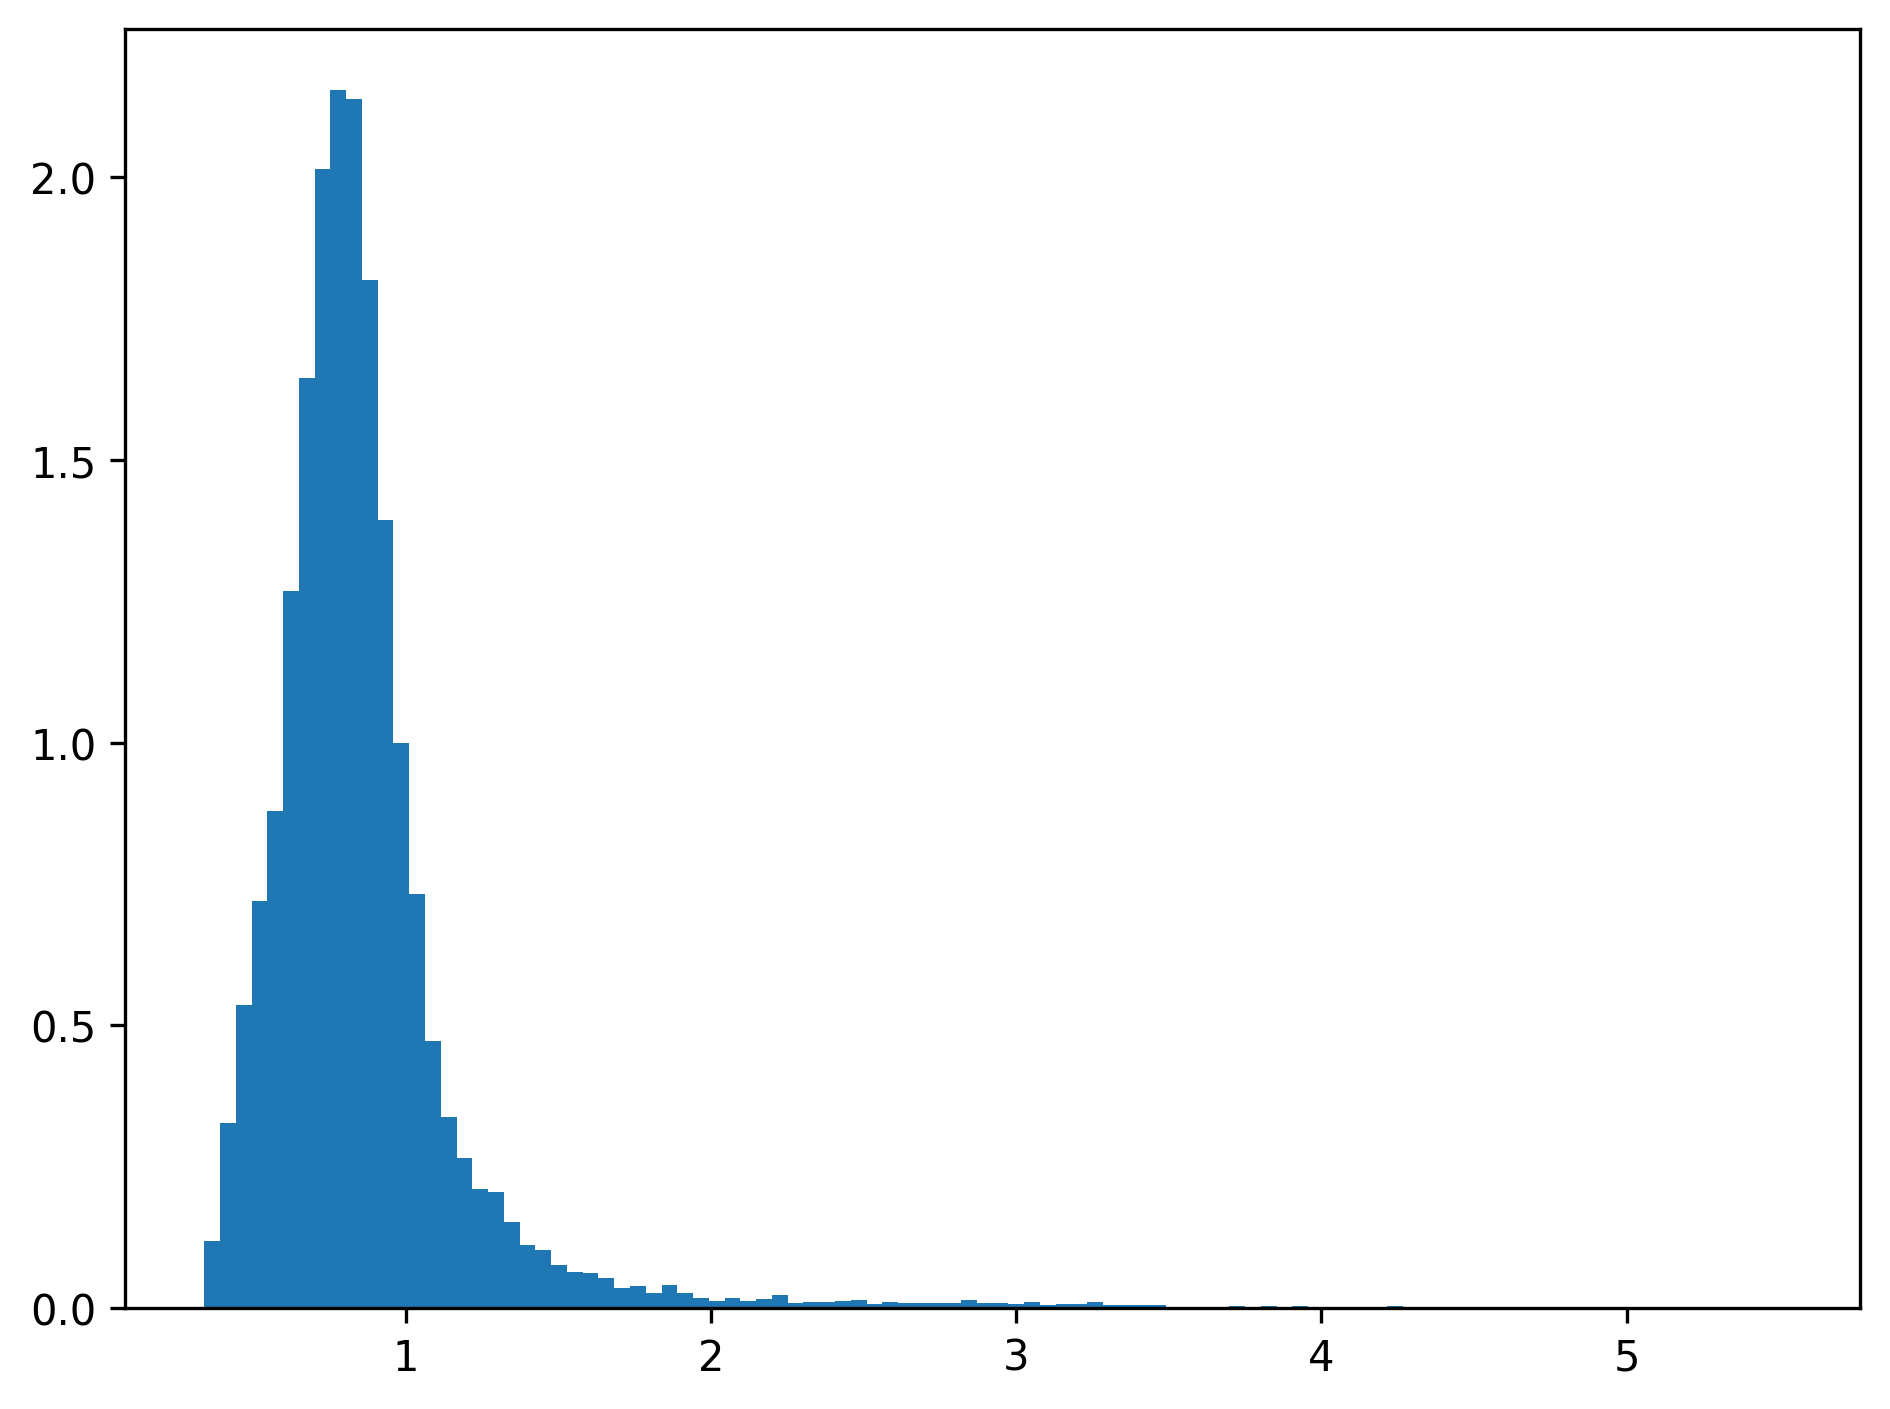

In [4]:
def pl_hist(df, column, n_bins=100,):
    data = df.select(pl.col(column))
    
    fig, ax = plt.subplots(1, 1, tight_layout=True)
    ax.hist(data, bins=n_bins, density=True)
    
    plt.show()
    plt.close()
    
pl_hist(exprData, "mean.cluster")

In [5]:
lfz = LegacyFuzzifier()

centers [0.4, 0.8, 1.2, 1.6, 2, 2.4]
Creating Universe Range 0.0 -> 8.0 with step size 0.1
Mean Expr mean.cluster col 7
Expr Count expr.cluster col 12
SD sd.cluster col 8
Cluster cluster col 0
Combining over state:  False


/mnt/raidbio/extproj/projekte/FlowSets/examples/../flowset.py:659: RuntimeWarning: invalid value encountered in divide
  values = fuzz.trimf(self.universe, abc)/unscaledValues


to_homogeneous: cluster.3
to_homogeneous: cluster.1
to_homogeneous: cluster.2


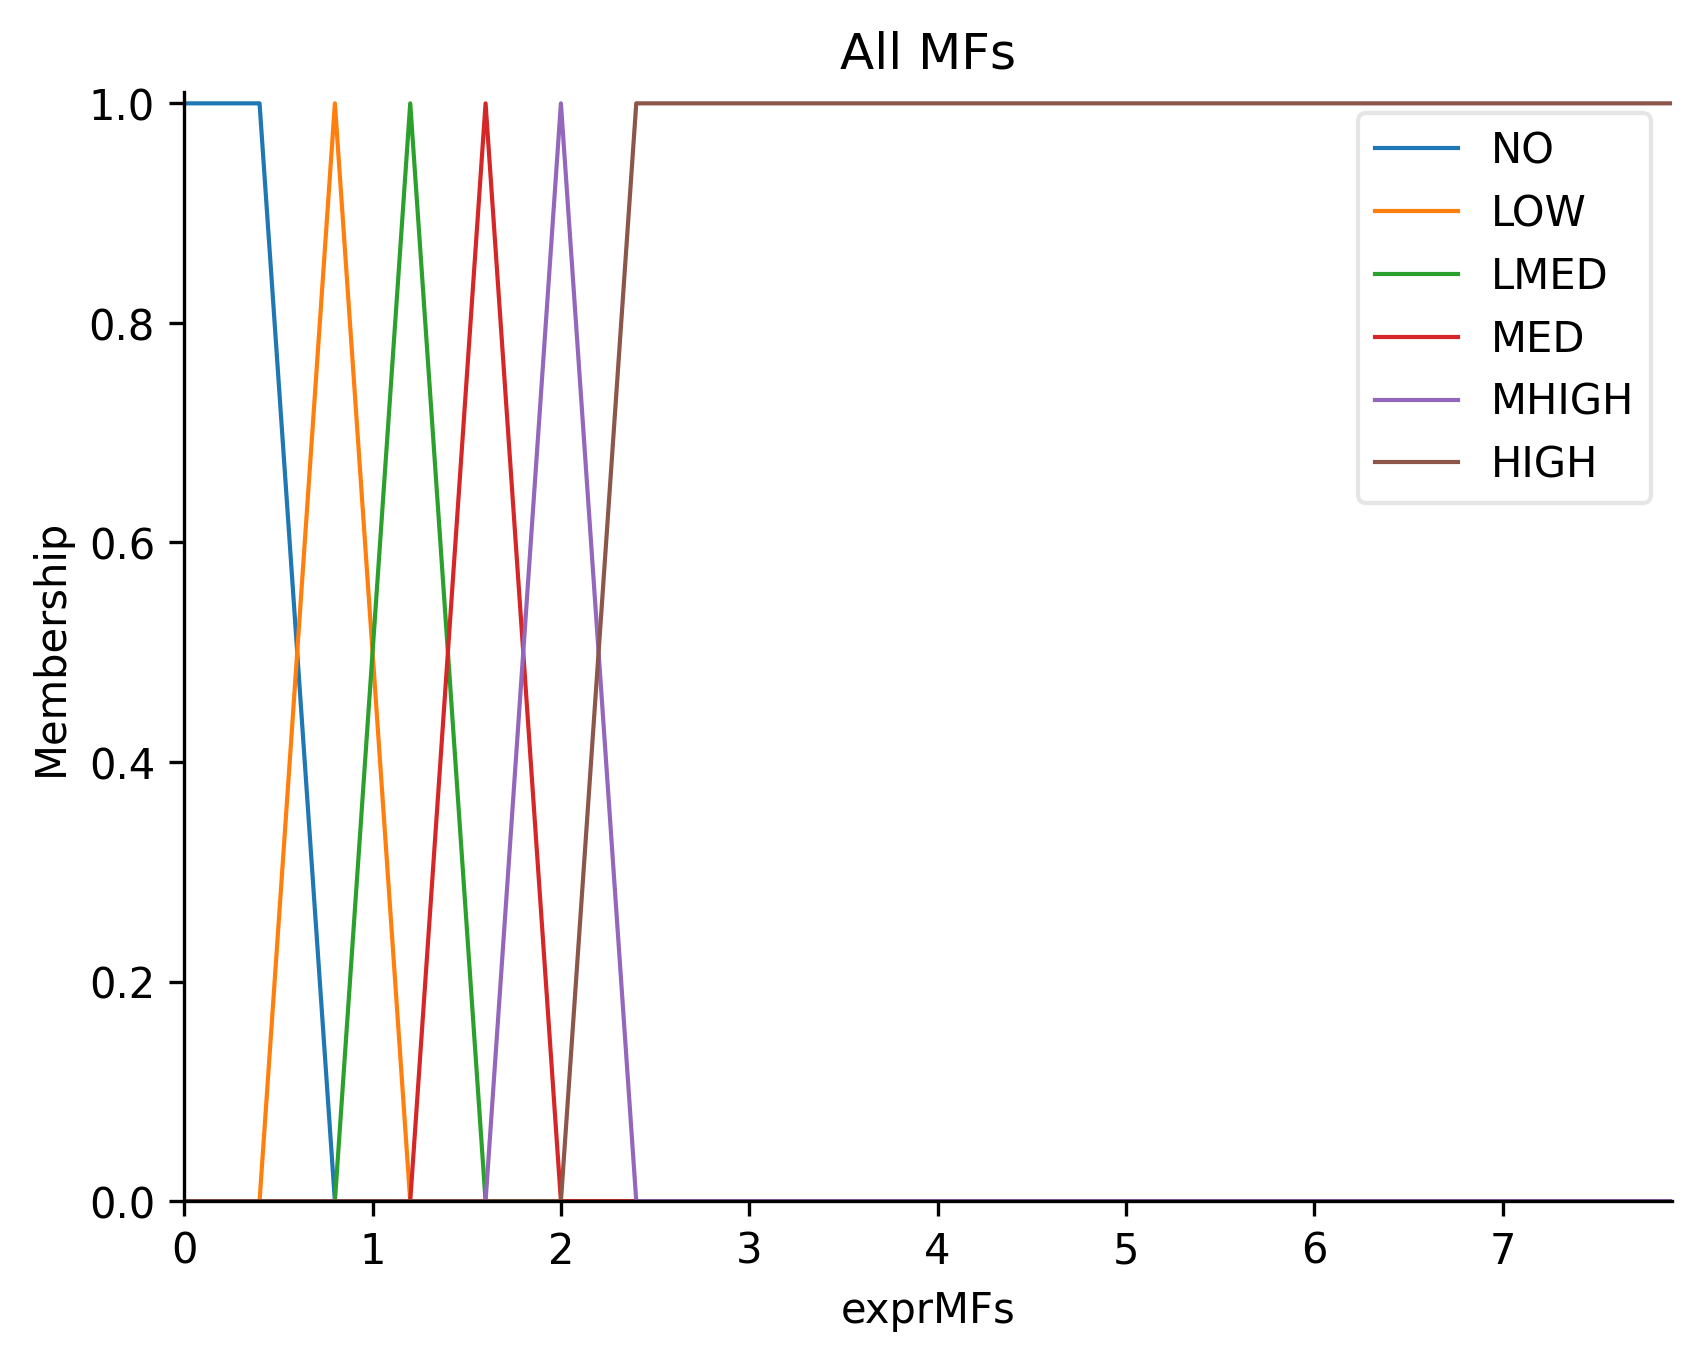

In [6]:
explDFWide, mfFuzzy = LegacyFuzzifier.fuzzify(exprData, stepsize=0.1, seriesOrder=["cluster.1","cluster.2","cluster.3"], mfLevels = ["NO","LOW","LMED","MED", "MHIGH", "HIGH"], centers=[0.4, 0.8, 1.2, 1.6, 2, 2.4]) #"cluster.thrombus"

In [7]:
isgListLong = sorted(set(["MX1","MX2","MT2A","RSAD2","SIGLEC1","IFIT1","IFI44","IFI27","IFITM10","IFIT3","IFI6","IFIT1P1","IFIT2","IFITM9P","IFI30","IFITM3","IFI44L","IFIT1B","IFITM5","IFITM3P2","IFITM3P9","IFI27L2","IFIT5","IFITM1","IFIH1","IFI16","IFI35","IFI27L1","IRF6","IRF7","IRF9","IRF5","IRF4","IRF2BP2","IRF2BPL","IRF3","IRF1-AS1","ISG15","ISG20L2","ISG20","XAF1","LY6E","IFITM2","IFITM3P6","IFITM3P3","IFIT6P","IRF2BP1","IRF5P1","IRF2","IRF1","IRF8","IFITM3P7","IFITM4P","IFITM3P1","IFITM3P8"]))
isgListShort = sorted(set(["MT2A", "ISG15", "LY6E", "IFIT1", "IFIT2", "IFIT3", "IFITM1", "IFITM3", "IFI44L", "IFI6", "MX1", "IFI27",  "IFI44L", "RSAD2", "SIGLEC1", "IFIT1"]))

In [8]:
fa = FlowAnalysis(explDFWide, "gene", (  ("1", "TP 1"),("2", "TP 2"),("3", "TP 3")), mfFuzzy, sep=".cluster.") #("thrombus", "Thrombus"),

In [9]:
import seaborn as sns

scm = fa._create_series_color_map(None, "scaling")
icefires = sns.color_palette("icefire", len(scm)+2)

sc = {x: scm[x](1.0) for xi, x in enumerate(scm)}
#sc = {x: icefires[xi+1] for xi, x in enumerate(scm)}
sc


{'TP 1': (0.267004, 0.004874, 0.329415, 1.0),
 'TP 2': (0.190631, 0.407061, 0.556089, 1.0),
 'TP 3': (0.20803, 0.718701, 0.472873, 1.0)}

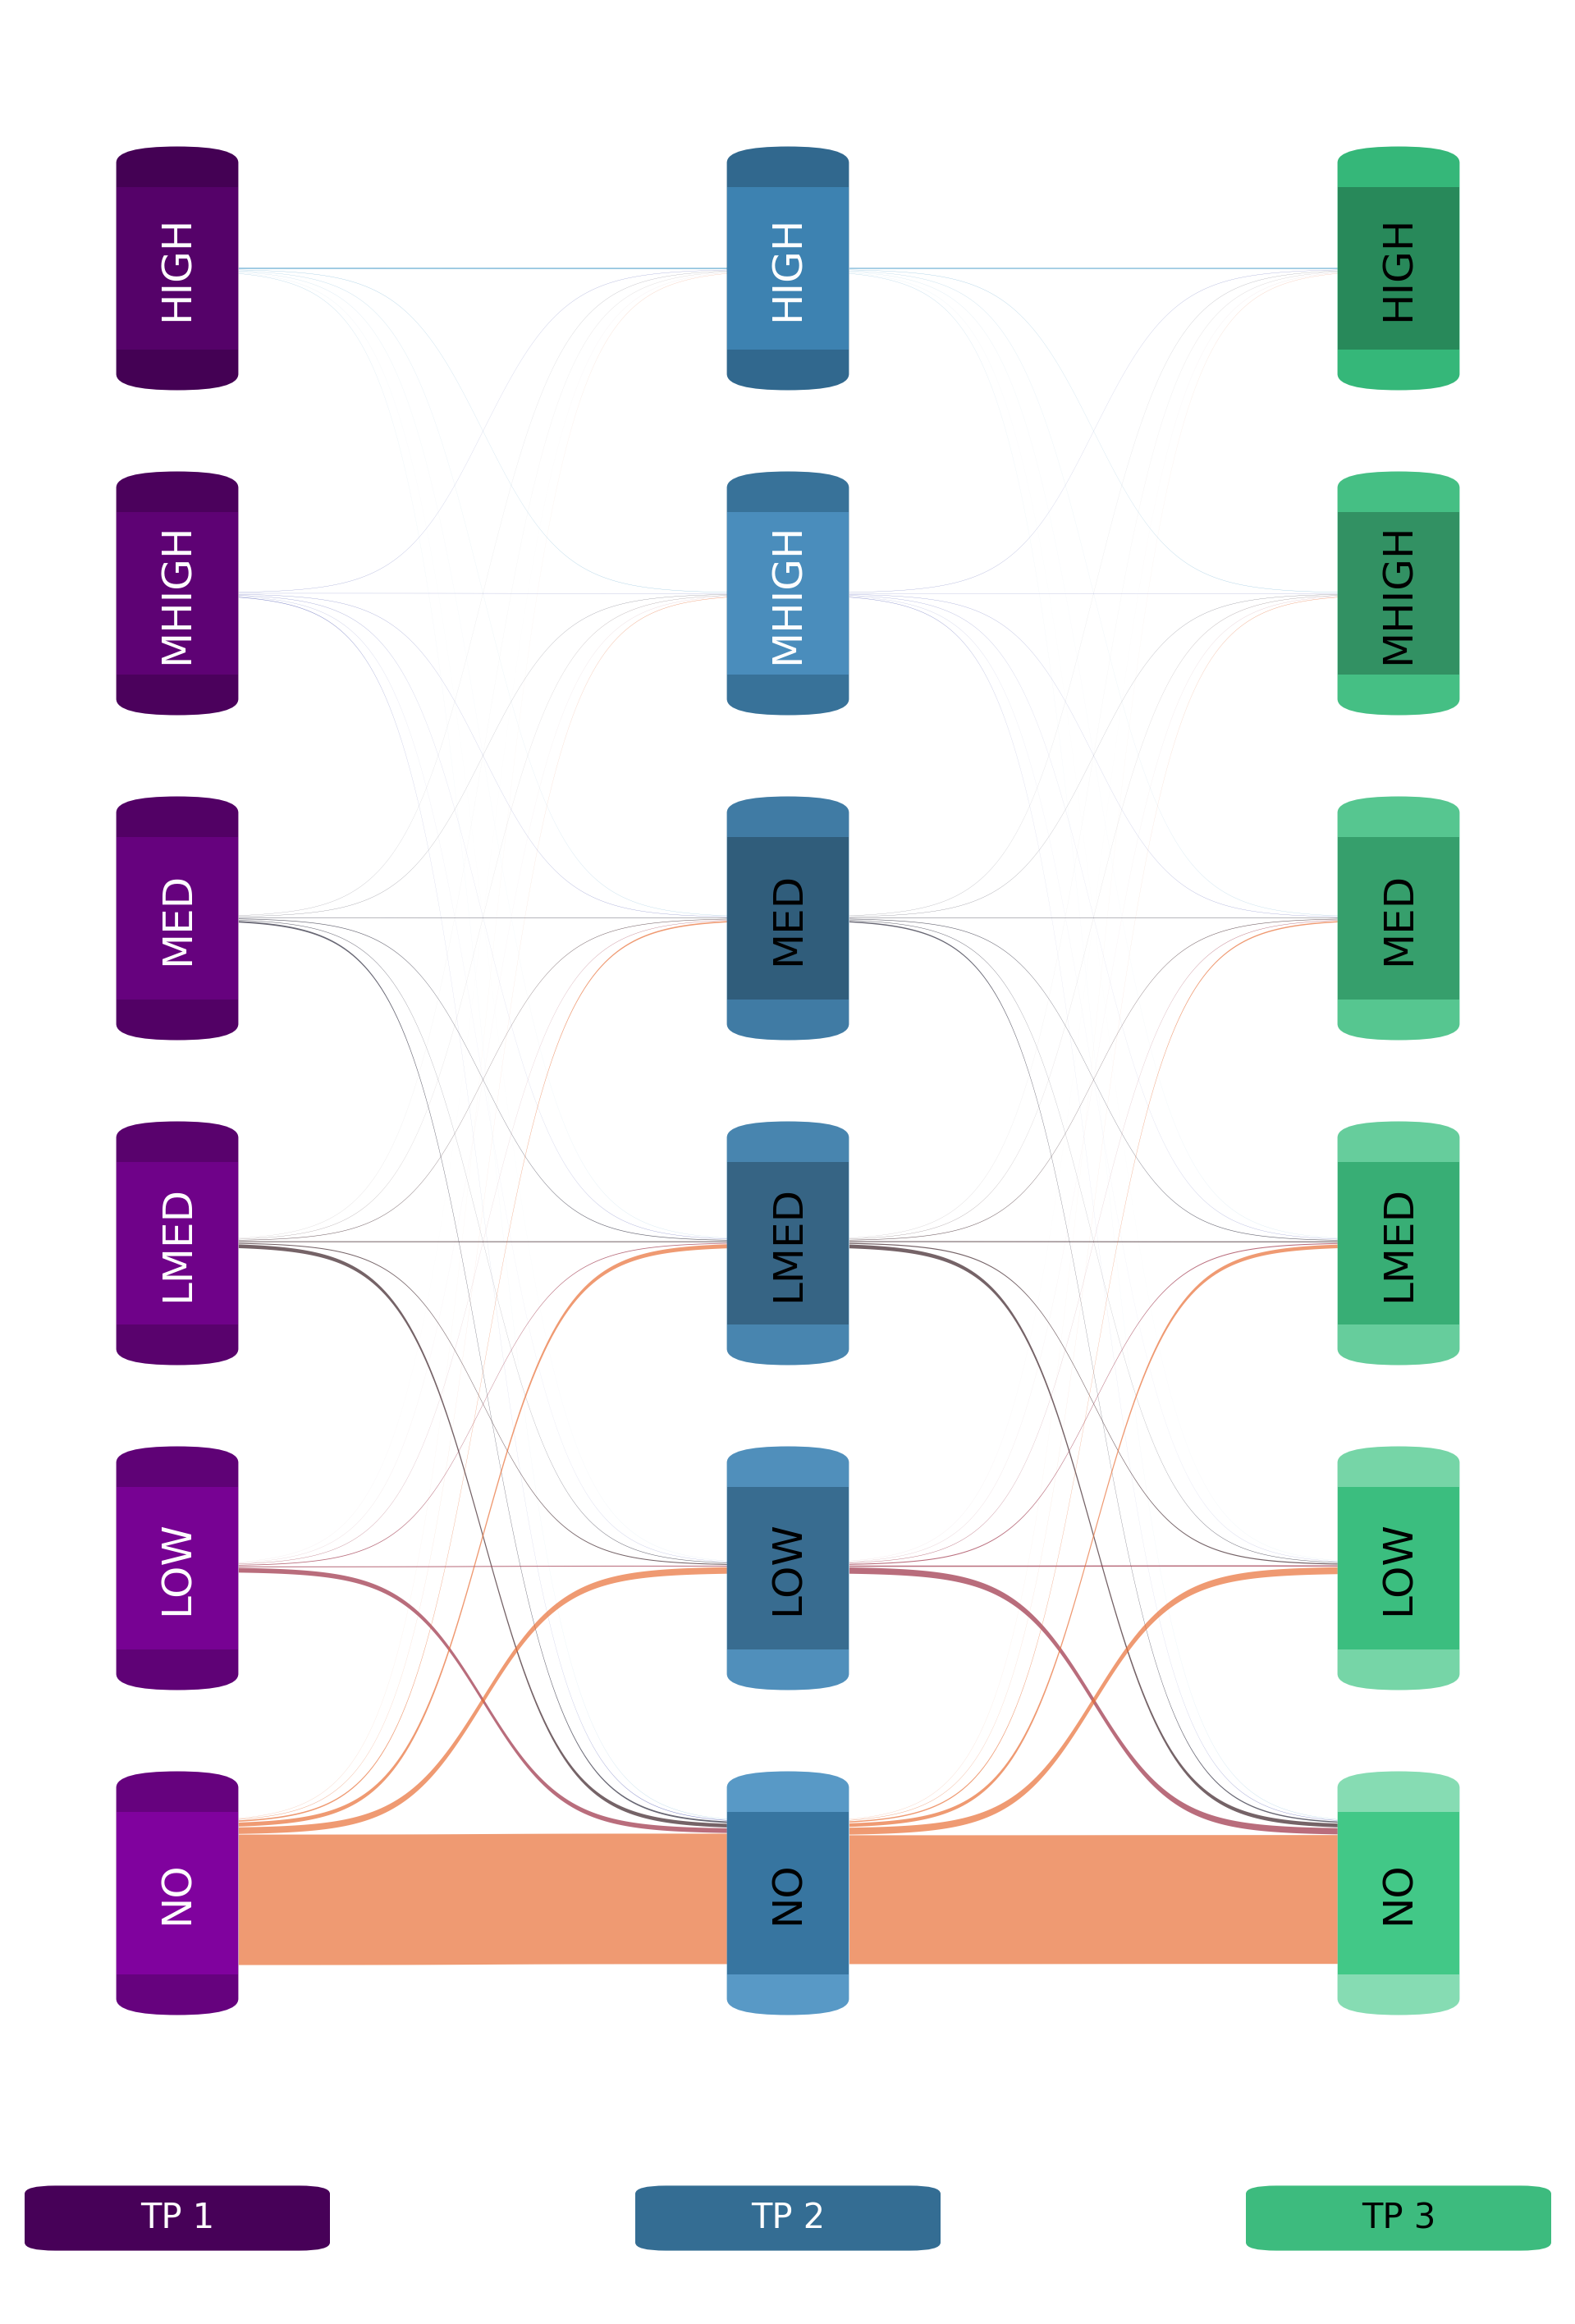

In [10]:
fa.plot_flows(verbose=False, seriesColors=sc, figsize=(8,12))

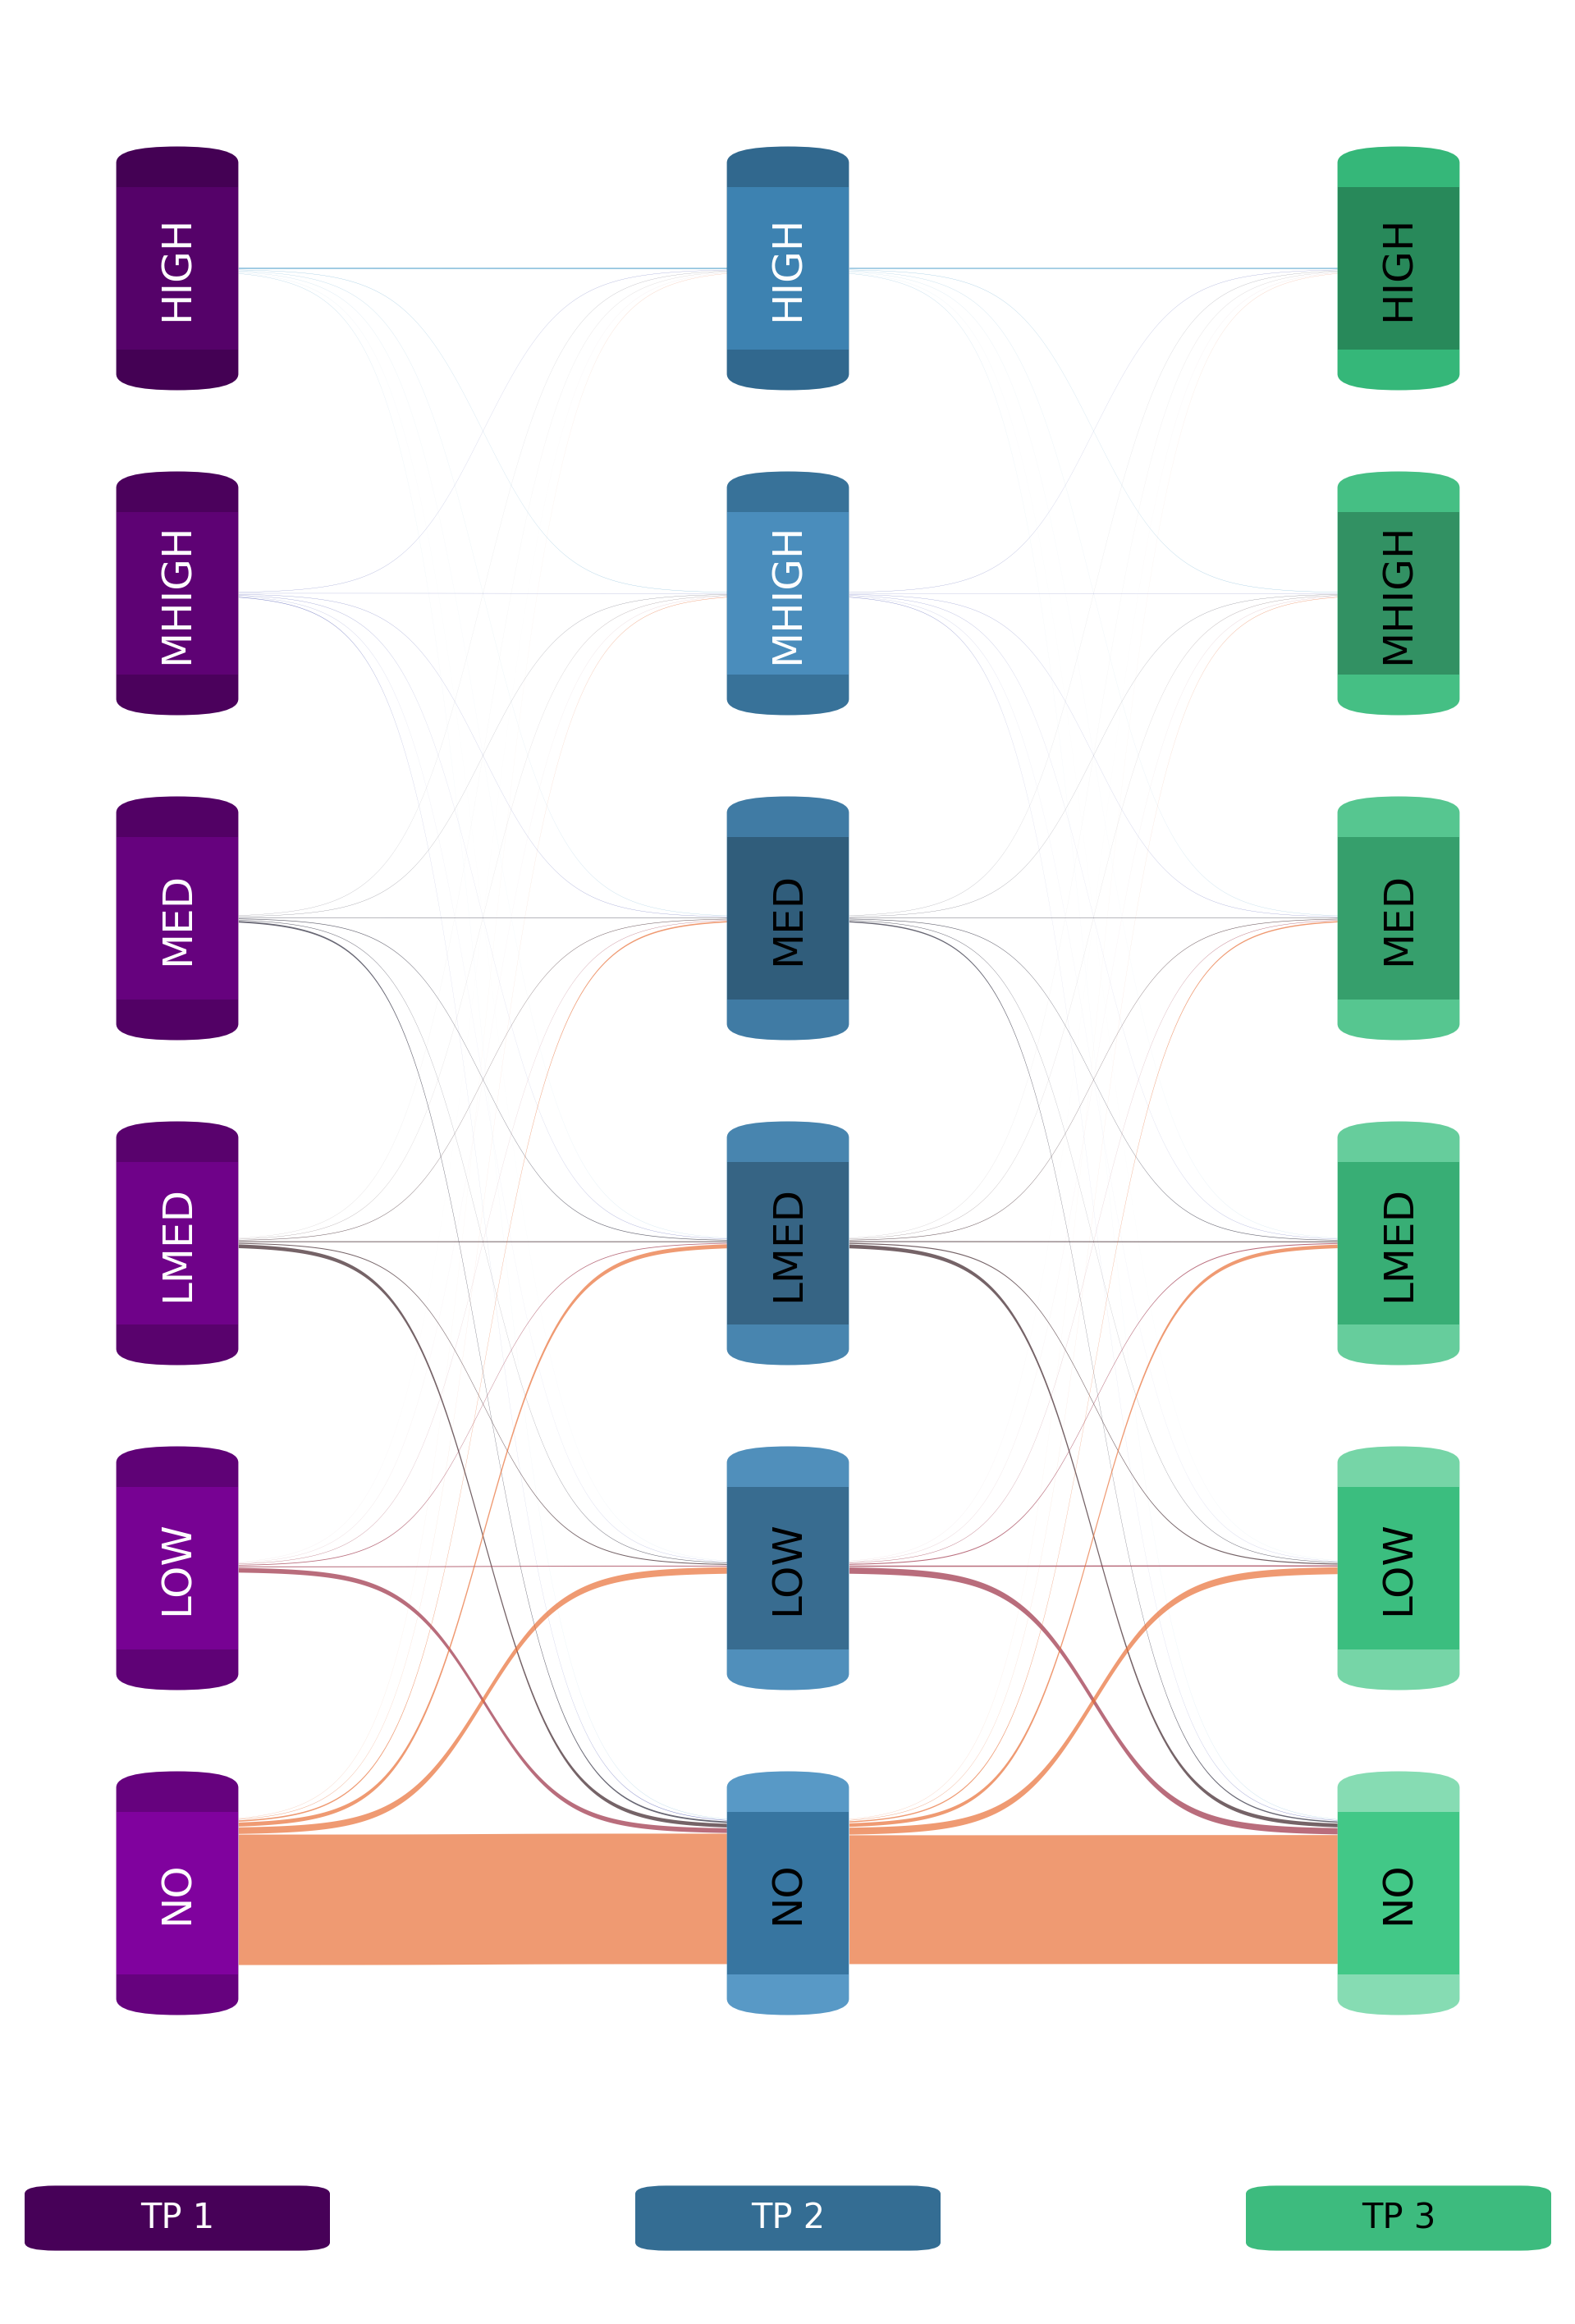

In [11]:
fa.plot_flows(outfile="plots/asympt_flows", seriesColors=sc, figsize=(8,12))

Creating FlowIDs
72 [('1', 'LMED'), ('2', 'NO'), ('3', 'NO')]
78 [('1', 'LMED'), ('2', 'LOW'), ('3', 'NO')]
79 [('1', 'LMED'), ('2', 'LOW'), ('3', 'LOW')]
108 [('1', 'MED'), ('2', 'NO'), ('3', 'NO')]
114 [('1', 'MED'), ('2', 'LOW'), ('3', 'NO')]
115 [('1', 'MED'), ('2', 'LOW'), ('3', 'LOW')]
120 [('1', 'MED'), ('2', 'LMED'), ('3', 'NO')]
121 [('1', 'MED'), ('2', 'LMED'), ('3', 'LOW')]
144 [('1', 'MHIGH'), ('2', 'NO'), ('3', 'NO')]
150 [('1', 'MHIGH'), ('2', 'LOW'), ('3', 'NO')]
151 [('1', 'MHIGH'), ('2', 'LOW'), ('3', 'LOW')]
156 [('1', 'MHIGH'), ('2', 'LMED'), ('3', 'NO')]
157 [('1', 'MHIGH'), ('2', 'LMED'), ('3', 'LOW')]
162 [('1', 'MHIGH'), ('2', 'MED'), ('3', 'NO')]
163 [('1', 'MHIGH'), ('2', 'MED'), ('3', 'LOW')]
180 [('1', 'HIGH'), ('2', 'NO'), ('3', 'NO')]
186 [('1', 'HIGH'), ('2', 'LOW'), ('3', 'NO')]
187 [('1', 'HIGH'), ('2', 'LOW'), ('3', 'LOW')]
192 [('1', 'HIGH'), ('2', 'LMED'), ('3', 'NO')]
193 [('1', 'HIGH'), ('2', 'LMED'), ('3', 'LOW')]
198 [('1', 'HIGH'), ('2', 'MED'), 

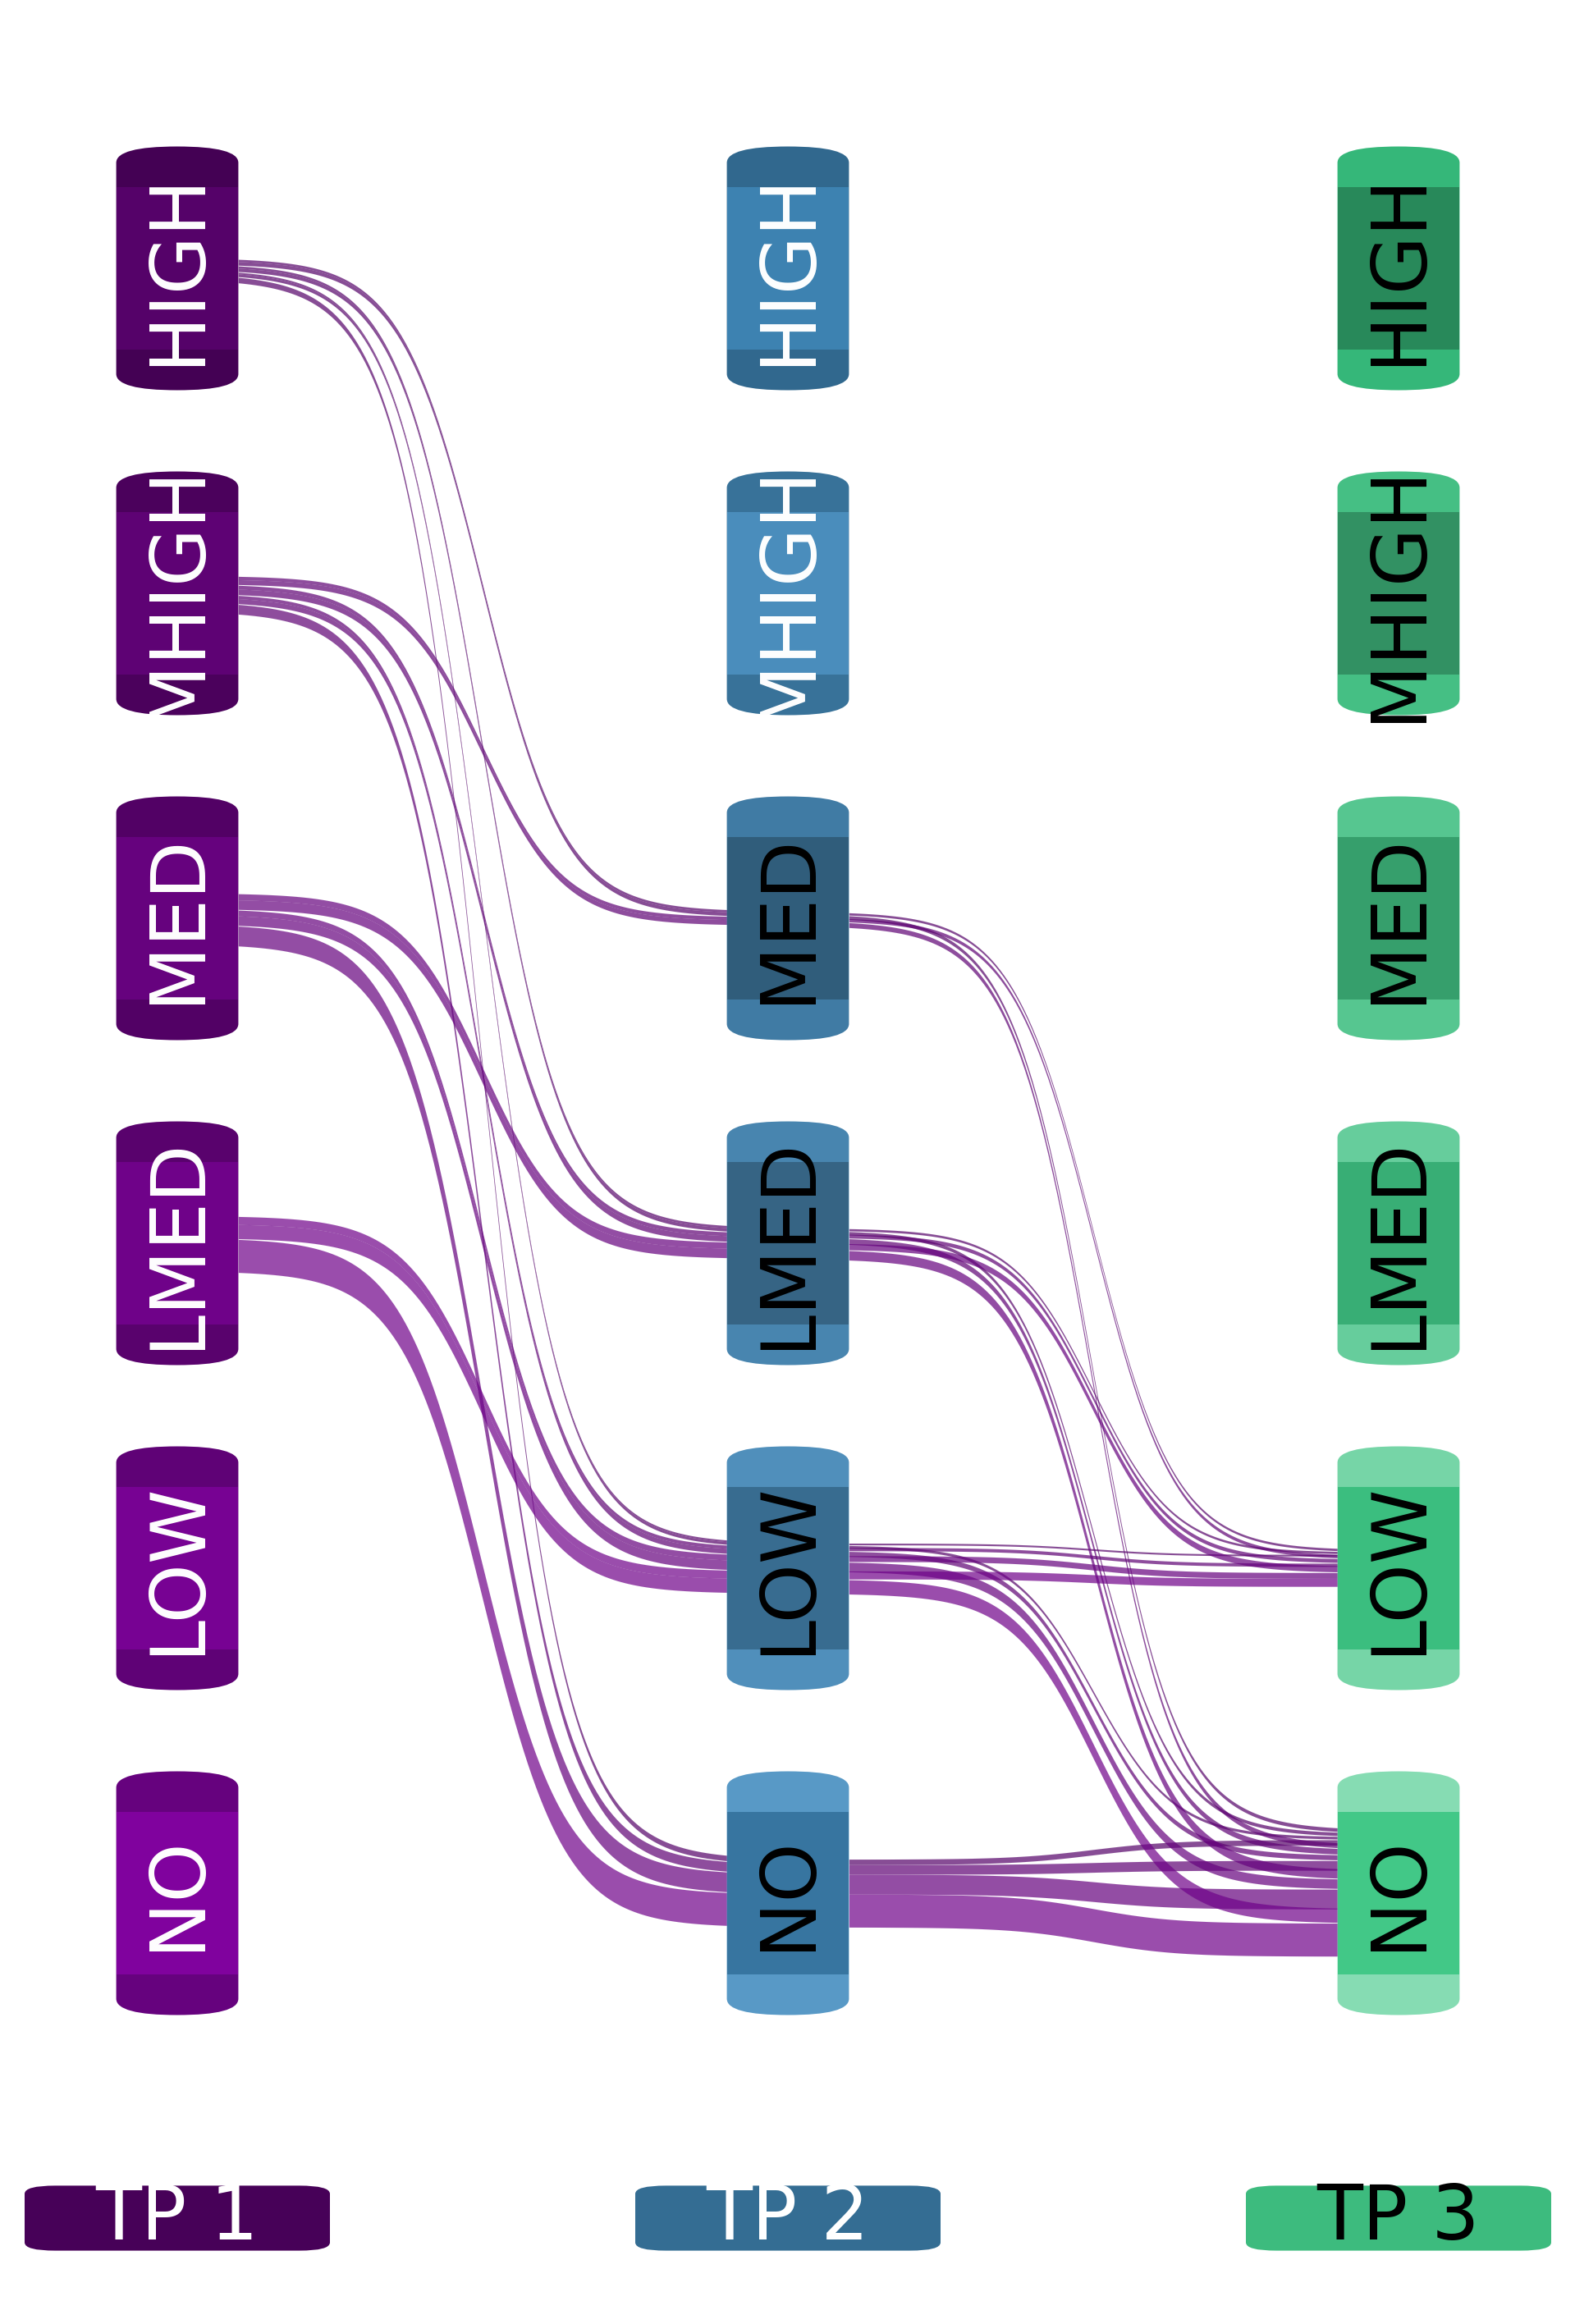

In [12]:
relFlows = fa.path_finder([">", ">="], minLevels=["LMED", None, None], maxLevels=["HIGH", "MED", "LOW"], verbose=True)

fa.plot_paths(use_flows=relFlows, seriesColors=sc, figsize=(8,12), outfile="plots/asympt_selected_paths")

In [13]:
# convert paths to edges

relEdges = fa.paths2edges(relFlows)

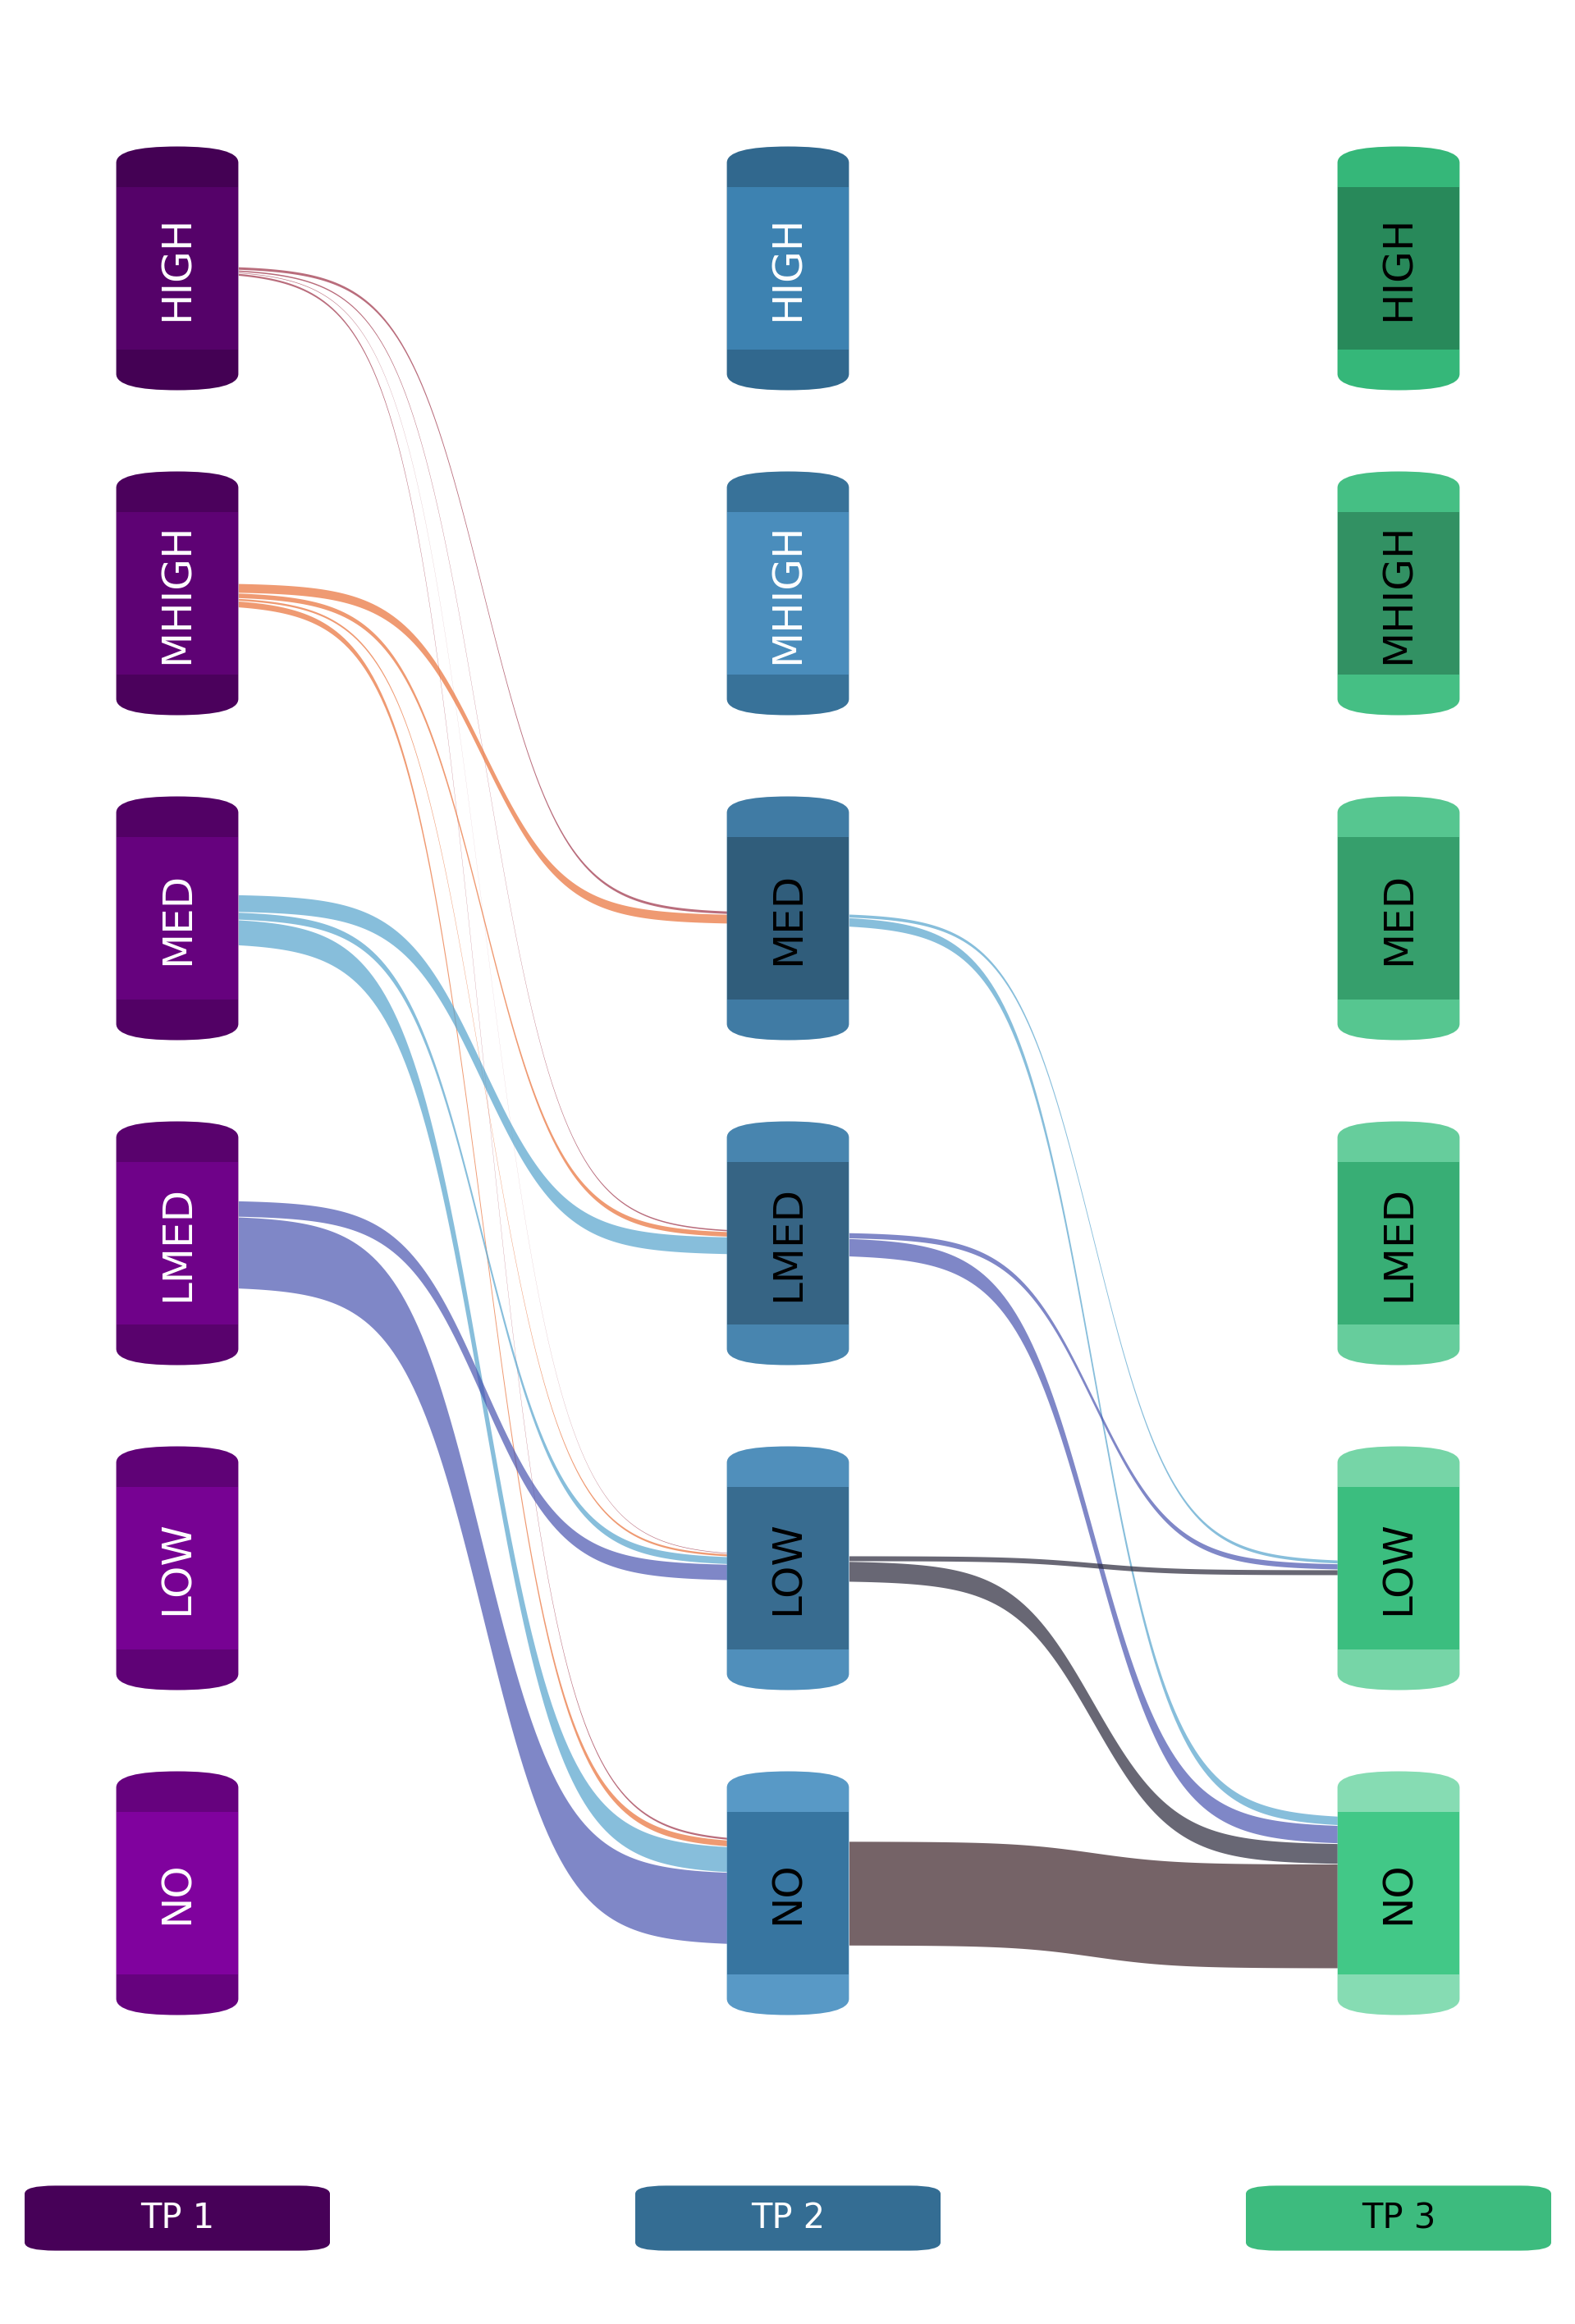

In [14]:
fa.plot_flows(relEdges, seriesColors=sc, figsize=(8,12), outfile="plots/asympt_selected_edges")

In [15]:
pwScoresGrp = fa.analyse_pathways(additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdges)
pwScoresGrp

Loading pathways from ReactomePathways.gmt
Identified 2612 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, 2605]


pwid                                             pwname  \
14     R-HSA-112122      ALKBH2 mediated reversal of alkylation damage   
17    R-HSA-5467333  APC truncation mutants are not K63 polyubiquit...   
30    R-HSA-9717264                     ASP-3026-resistant ALK mutants   
46    R-HSA-2978092  Abnormal conversion of 2-oxoglutarate to 2-hyd...   
160    R-HSA-211957  Aromatic amines can be N-hydroxylated or N-dea...   
...             ...                                                ...   
2566    R-HSA-72172                                      mRNA Splicing   
2567    R-HSA-72163                      mRNA Splicing - Major Pathway   
2592    R-HSA-72312                                    rRNA processing   
2594  R-HSA-8868773         rRNA processing in the nucleus and cytosol   
2603    R-HSA-72306                                    tRNA processing   

         pwFlow  pwGenes   allPwFlow   allPwGenes  pw_gene_intersection  \
14     0.006230        1  554.109292  7670.000144                     1   
17     0.057277        1  554.109292  7670.000144                     1   
30     0.000000        1  554.109292  7670.000144                     0   
46     0.033405        1  554.109292  7670.000144                     1   
160    0.000000        1  554.109292  7670.000144                     0   
...         ...      ...         ...          ...                   ...   
2566  16.995422      215  554.109292  7670.000144                   209   
2567  16.704045      204  554.109292  7670.000144                   201   
2592   6.050386      237  554.109292  7670.000144                   210   
2594   5.777972      199  554.109292  7670.000144                   188   
2603   3.663902      146  554.109292  7670.000144                   119   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
14       0.006230        0.000011   7.005444e-08           -0.844313   
17       0.057277        0.000103   5.920523e-06            0.315438   
30       0.000000        0.000000   0.000000e+00           -0.985866   
46       0.033405        0.000060   2.013904e-06           -0.226907   
160      0.000000        0.000000   0.000000e+00           -0.985866   
...           ...             ...            ...                 ...   
2566     0.079048        0.030672   2.424544e-03            1.976449   
2567     0.081883        0.030146   2.468412e-03            2.134135   
2592     0.025529        0.010919   2.787548e-04           -1.001304   
2594     0.029035        0.010427   3.027627e-04           -0.806235   
2603     0.025095        0.006612   1.659356e-04           -1.025442   

      pw_coverage_pval  pw_coverage_adj_pval  
14            1.000000              1.000000  
17            0.376215              1.000000  
30            1.000000              1.000000  
46            1.000000              1.000000  
160           1.000000              1.000000  
...                ...                   ...  
2566          0.024052              0.840415  
2567          0.016416              0.780201  
2592          1.000000              1.000000  
2594          1.000000              1.000000  
2603          1.000000              1.000000  

[2614 rows x 13 columns]

pwid                                             pwname  \
2612      ISG_SHORT                                          ISG_SHORT   
418   R-HSA-3134963  DEx/H-box helicases activate type I IFN and in...   
1876  R-HSA-9707587        Regulation of HMOX1 expression and activity   
1257  R-HSA-2644607  Loss of Function of FBXW7 in Cancer and NOTCH1...   
899    R-HSA-163210          Formation of ATP by chemiosmotic coupling   
848   R-HSA-2644605                 FBXW7 Mutants and NOTCH1 in Cancer   
1964   R-HSA-163200  Respiratory electron transport, ATP synthesis ...   
1963   R-HSA-611105                     Respiratory electron transport   
2040  R-HSA-3065676               SUMO is conjugated to E1 (UBA2:SAE1)   
2613       ISG_LONG                                           ISG_LONG   
1312  R-HSA-2206292                             MPS VII - Sly syndrome   
397   R-HSA-1236978  Cross-presentation of soluble exogenous antige...   
1910   R-HSA-211733  Regulation of activated PAK-2p34 by proteasome...   
2289  R-HSA-6791055  TALDO1 deficiency: failed conversion of SH7P, ...   
2288  R-HSA-6791462  TALDO1 deficiency: failed conversion of  Fru(6...   
2362   R-HSA-844456                             The NLRP3 inflammasome   
1880   R-HSA-877312                       Regulation of IFNG signaling   
1545  R-HSA-8983711                             OAS antiviral response   
468   R-HSA-9734195            Defective APRT disrupts adenine salvage   
653   R-HSA-5660862  Defective SLC7A7 causes lysinuric protein into...   

         pwFlow  pwGenes   allPwFlow   allPwGenes  pw_gene_intersection  \
2612   4.426666       14  554.109292  7670.000144                    14   
418    1.142684        7  554.109292  7670.000144                     7   
1876   0.747010        5  554.109292  7670.000144                     5   
1257   0.663965        5  554.109292  7670.000144                     5   
899    2.139342       18  554.109292  7670.000144                    18   
848    0.663965        5  554.109292  7670.000144                     5   
1964  12.298157      127  554.109292  7670.000144                   124   
1963   9.931791      103  554.109292  7670.000144                   103   
2040   0.641740        5  554.109292  7670.000144                     5   
2613   7.809421       55  554.109292  7670.000144                    40   
1312   0.175792        1  554.109292  7670.000144                     1   
397    5.535464       50  554.109292  7670.000144                    45   
1910   5.611500       50  554.109292  7670.000144                    48   
2289   0.169741        1  554.109292  7670.000144                     1   
2288   0.169741        1  554.109292  7670.000144                     1   
2362   1.810661       17  554.109292  7670.000144                    16   
1880   1.473746       14  554.109292  7670.000144                    14   
1545   1.188536       10  554.109292  7670.000144                     8   
468    0.166048        1  554.109292  7670.000144                     1   
653    0.311530        2  554.109292  7670.000144                     2   

      pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
2612     0.316190        0.007989       0.002526           11.795422   
418      0.163241        0.002062       0.000337            4.283842   
1876     0.149402        0.001348       0.000201            3.808052   
1257     0.132793        0.001198       0.000159            3.237008   
899      0.118852        0.003861       0.000459            3.337672   
848      0.132793        0.001198       0.000159            3.237008   
1964     0.096836        0.022194       0.002149            2.966118   
1963     0.096425        0.017924       0.001728            2.943266   
2040     0.128348        0.001158       0.000149            3.084184   
2613     0.141989        0.014094       0.002001            3.059802   
1312     0.175792        0.000317       0.000056            3.008053   
397      0.110709   

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(10, 14)


/mnt/raidbio/extproj/projekte/FlowSets/examples/../flowset.py:2853: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


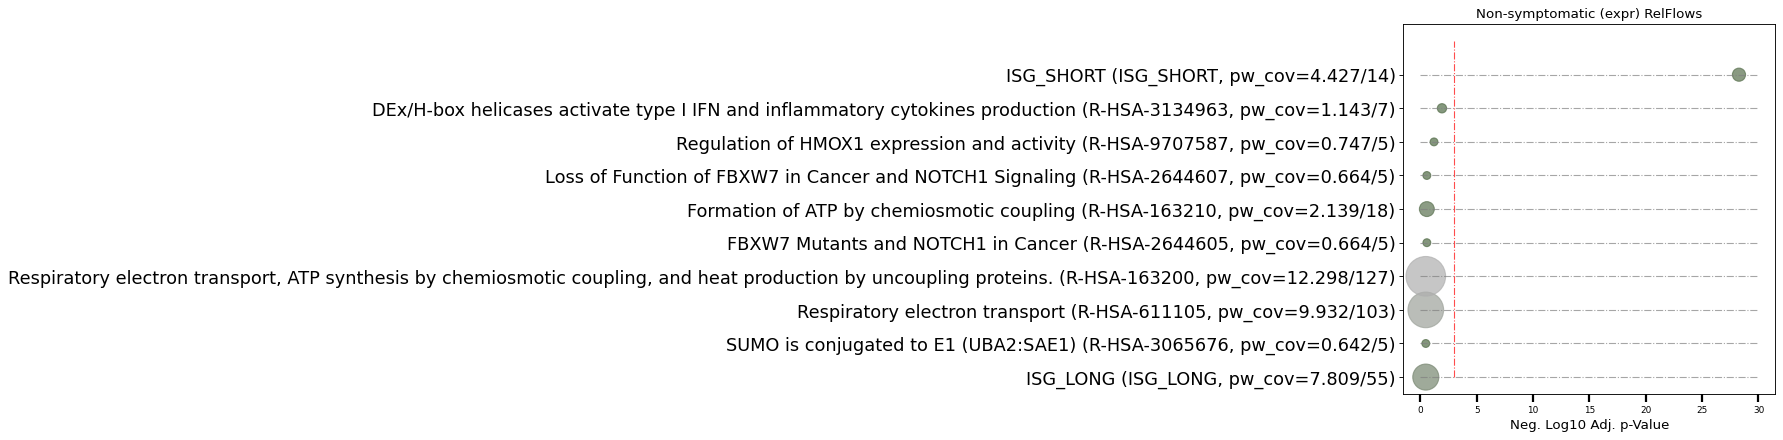

In [16]:
selPWsGrp = pwScoresGrp[(pwScoresGrp["pw_coverage_adj_pval"] < 1)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsGrp)
fa.plotORAresult(selPWsGrp, "Non-symptomatic (expr) RelFlows", numResults=10, figsize=(6,6), outfile="plots/asympt_ra")

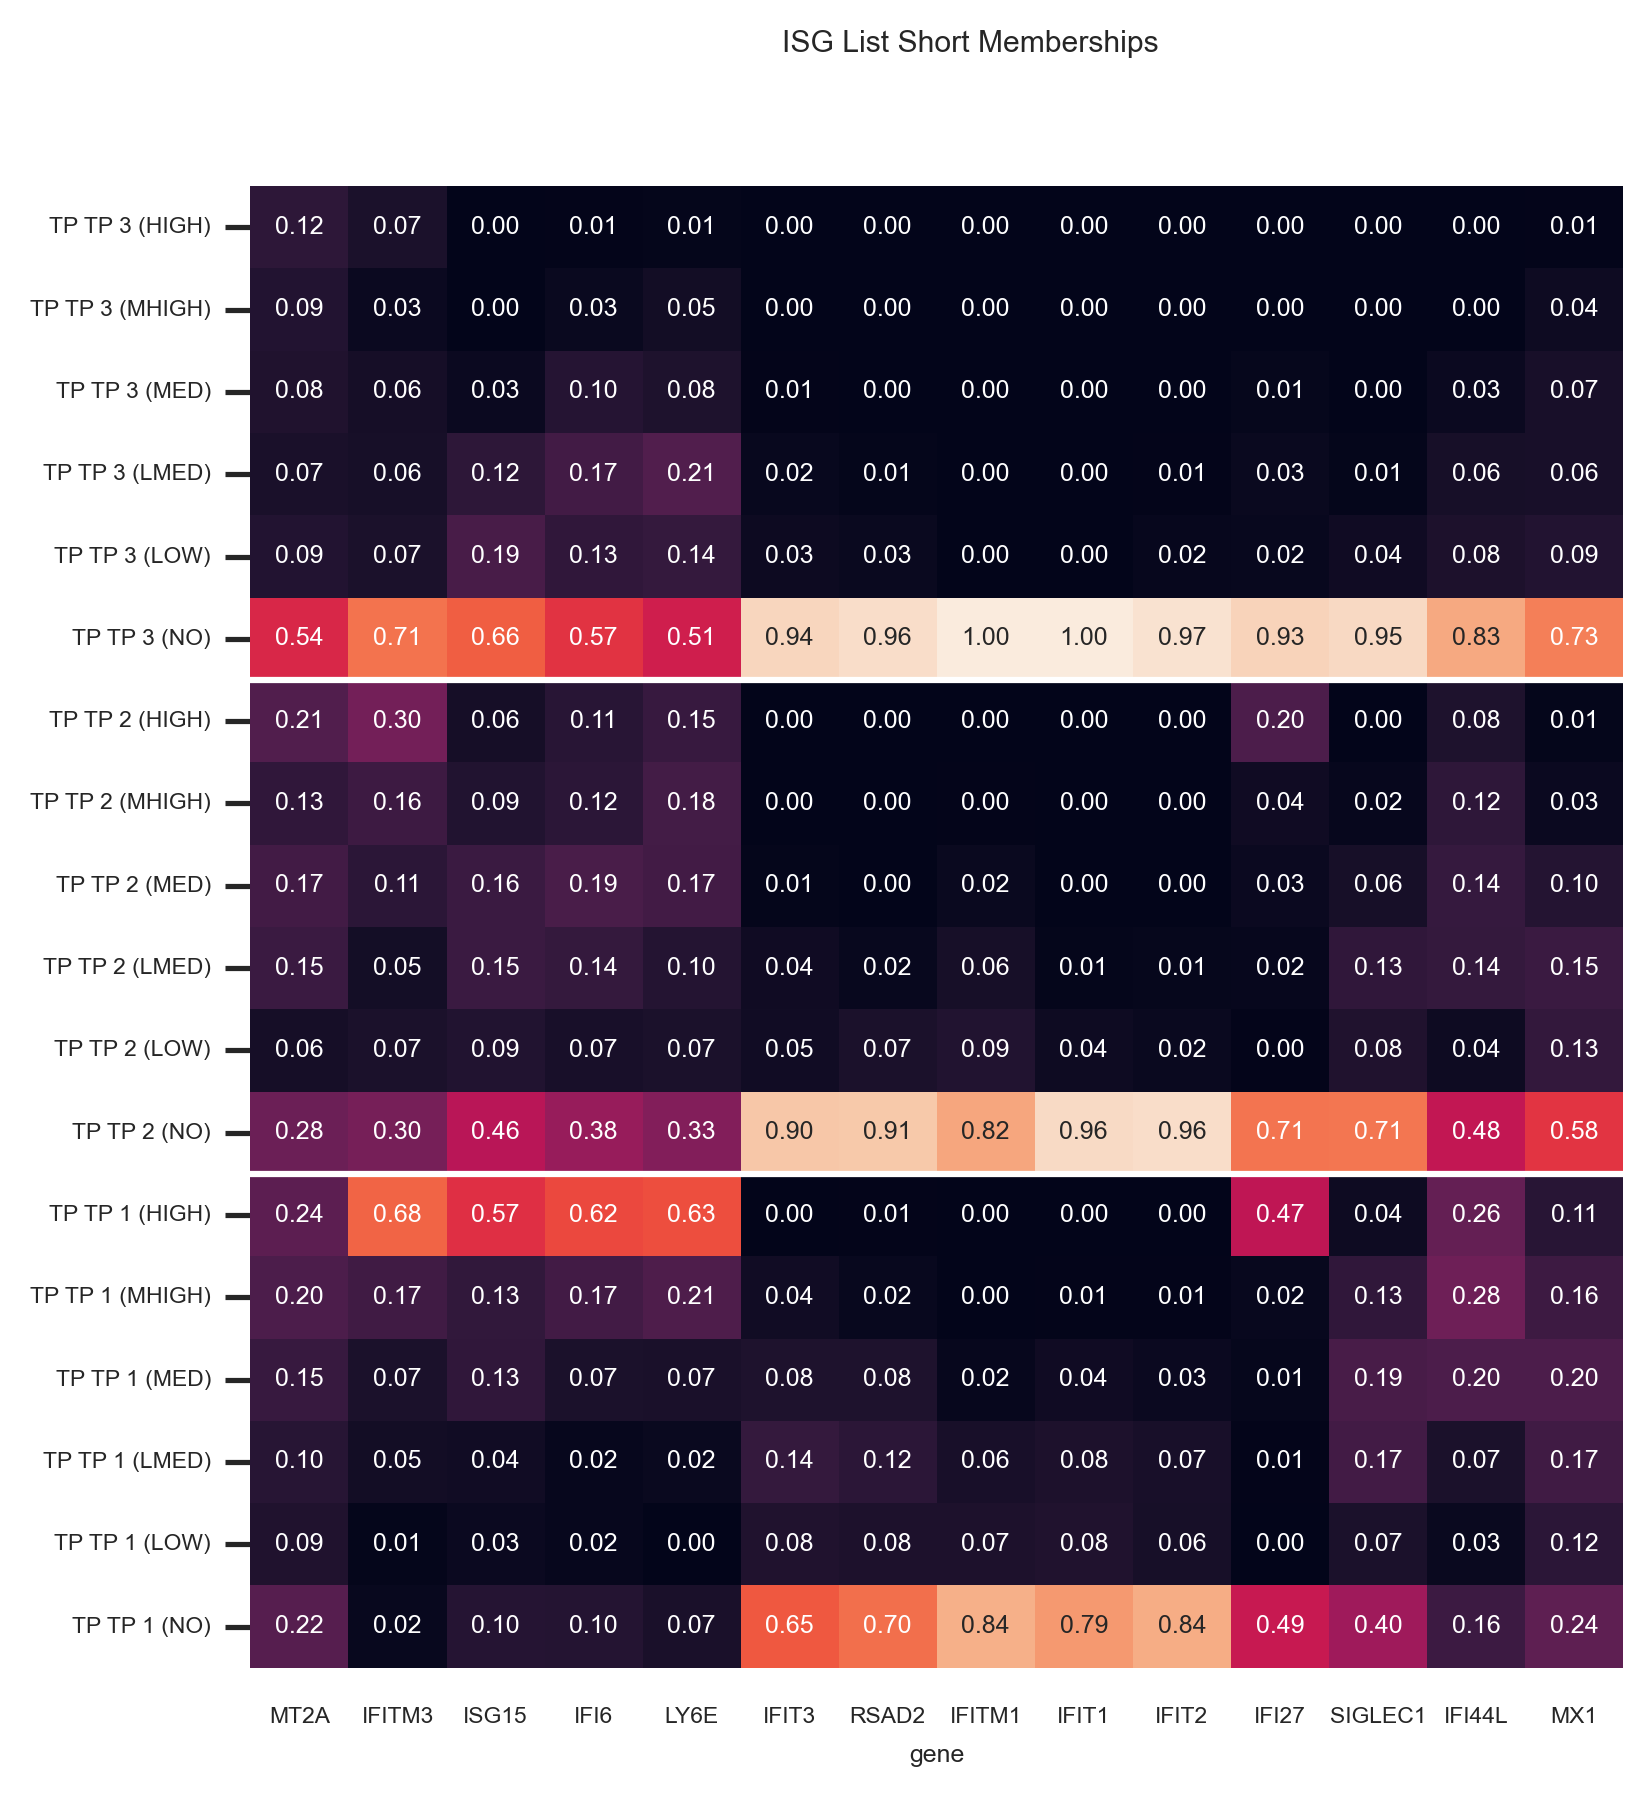

In [17]:
_=fa.plot_state_memberships(genes=isgListShort, name="ISG List Short Memberships", cluster_genes=True, outfile="plots/asympt_memberships", prefix="TP", font_scale=0.5)

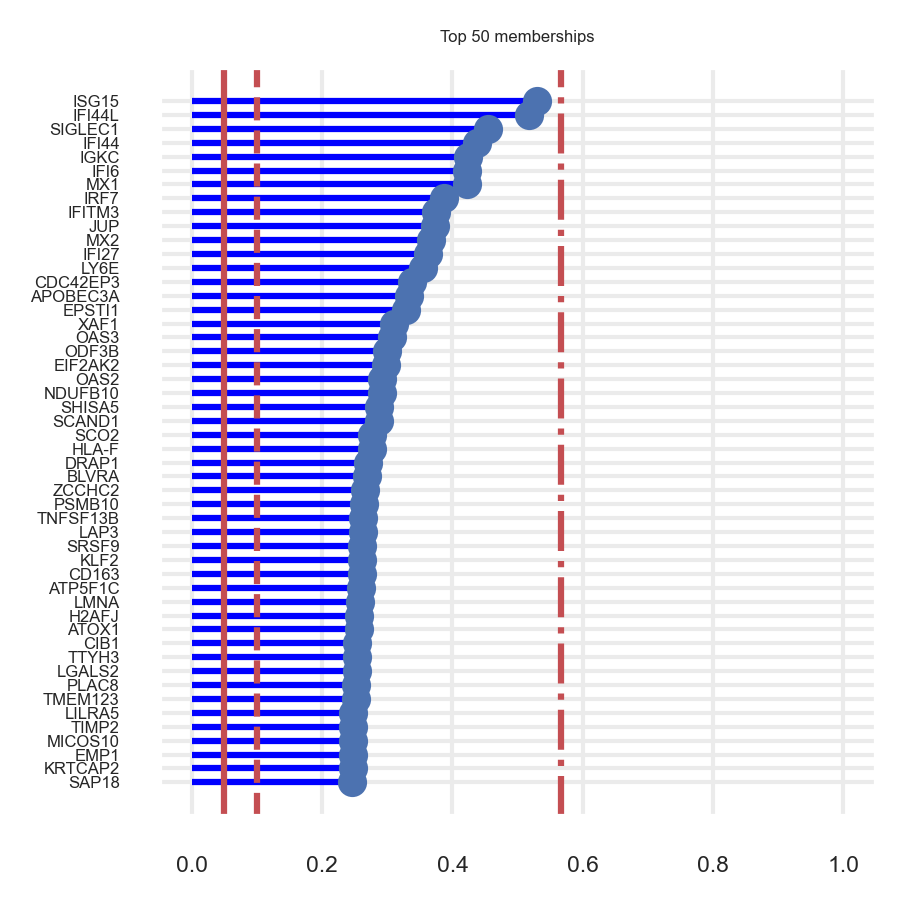

In [18]:
_=fa.plot_flow_memberships(use_edges=relEdges, outfile="plots/asympt_flow_memberships", n_genes=50, gene_exclude_patterns=["AC", "AF", "AL", "LINC"], figsize=(3,3), plot_histogram=False)

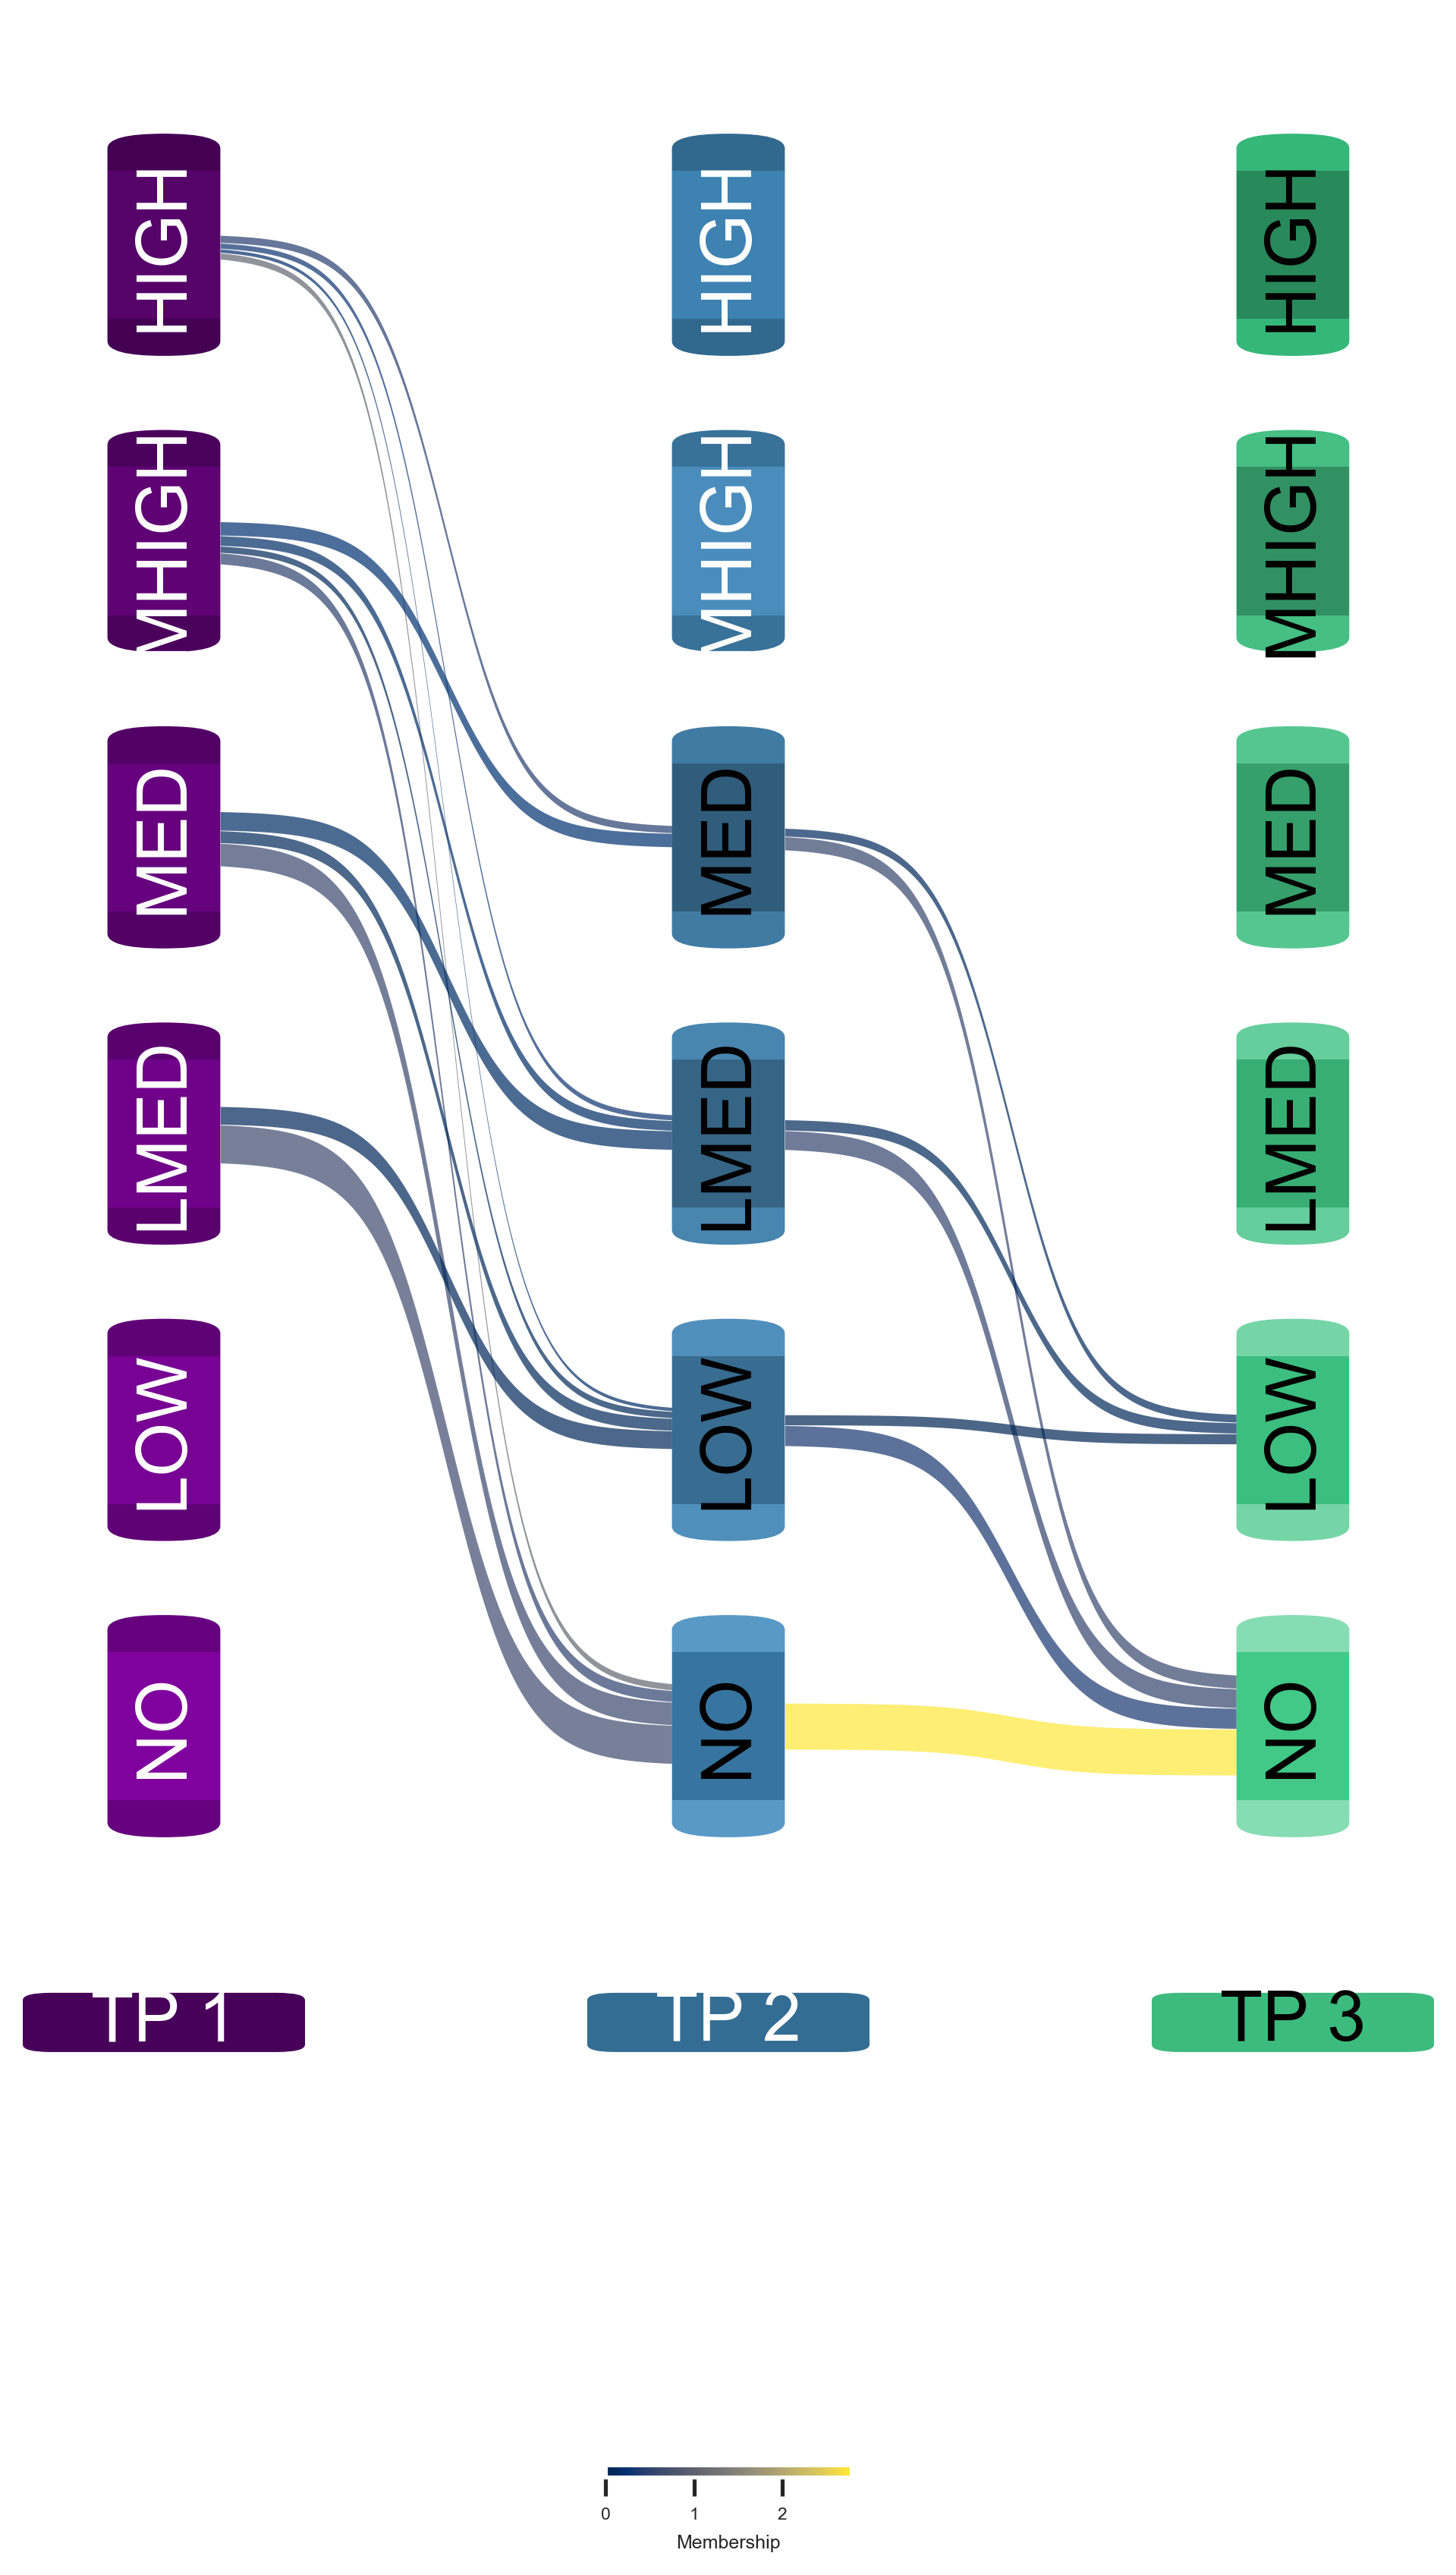

In [19]:
_=fa.visualize_genes(genes=isgListShort, use_edges=relEdges, outfile="plots/asympt_isg_flow", figsize=(8,14), seriesColors=sc)

In [20]:
pwScoresGrpGO = fa.analyse_pathways(genesets_file="go_human.bp.gmt", additional_genesets=[("ISG_SHORT", isgListShort), ("ISG_LONG", isgListLong)], use_edges=relEdges)
pwScoresGrpGO

Loading pathways from go_human.bp.gmt
Identified 12535 pathways
Calculating p-values for groups [1, 2, 3, 4, 10, 50, 100, 1226]


pwid                                             pwname    pwFlow  \
7     GO:0010789  meiotic sister chromatid cohesion involved in ...  0.000000   
20    GO:1900101  regulation of endoplasmic reticulum unfolded p...  0.012283   
25    GO:0043610             regulation of carbohydrate utilization  0.000000   
28    GO:0072522    purine-containing compound biosynthetic process  0.000000   
53    GO:0043416  regulation of skeletal muscle tissue regeneration  0.000000   
...          ...                                                ...       ...   
1774  GO:0010976  positive regulation of neuron projection devel...  3.481158   
1860  GO:0001822                                 kidney development  2.454124   
1861  GO:0007568                                              aging  5.301791   
1881  GO:0018108                  peptidyl-tyrosine phosphorylation  4.835455   
2493  GO:0006457                                    protein folding  7.543425   

      pwGenes   allPwFlow    allPwGenes  pw_gene_intersection  pw_coverage  \
7           1  554.109292  11415.000211                     1     0.000000   
20          1  554.109292  11415.000211                     1     0.012283   
25          1  554.109292  11415.000211                     0     0.000000   
28          1  554.109292  11415.000211                     0     0.000000   
53          1  554.109292  11415.000211                     0     0.000000   
...       ...         ...           ...                   ...          ...   
1774      111  554.109292  11415.000211                    73     0.031362   
1860      115  554.109292  11415.000211                    64     0.021340   
1861      146  554.109292  11415.000211                   102     0.036314   
1881      139  554.109292  11415.000211                    99     0.034787   
2493      156  554.109292  11415.000211                   123     0.048355   

      genes_coverage  mean_coverage  pw_coverage_zscore  pw_coverage_pval  \
7           0.000000   0.000000e+00           -1.011367          1.000000   
20          0.000022   2.722757e-07           -0.794897          1.000000   
25          0.000000   0.000000e+00           -1.011367          1.000000   
28          0.000000   0.000000e+00           -1.011367          1.000000   
53          0.000000   0.000000e+00           -1.011367          1.000000   
...              ...            ...                 ...               ...   
1774        0.006282   1.970285e-04           -0.238454          1.000000   
1860        0.004429   9.451479e-05           -0.954428          1.000000   
1861        0.009568   3.474536e-04            0.115323          0.454095   
1881        0.008727   3.035739e-04            0.006287          0.497492   
2493        0.013614   6.582898e-04            0.975619          0.164627   

      pw_coverage_adj_pval  
7                      1.0  
20                     1.0  
25                     1.0  
28                     1.0  
53                     1.0  
...                    ...  
1774                   1.0  
1860                   1.0  
1861                   1.0  
1881                   1.0  
2493                   1.0  

[12537 rows x 13 columns]

pwid                                             pwname  \
12535   ISG_SHORT                                          ISG_SHORT   
5175   GO:0070106          interleukin-27-mediated signaling pathway   
2460   GO:0035456                        response to interferon-beta   
5995   GO:0032020                          ISG15-protein conjugation   
7070   GO:0035455                       response to interferon-alpha   
12536    ISG_LONG                                           ISG_LONG   
4936   GO:0034340                      response to type I interferon   
397    GO:0045071    negative regulation of viral genome replication   
988    GO:0042776  proton motive force-driven mitochondrial ATP s...   
7189   GO:0036261             7-methylguanosine cap hypermethylation   
987    GO:0009060                                aerobic respiration   
3296   GO:1903241                    U2-type prespliceosome assembly   
396    GO:0009615                                  response to virus   
8673   GO:0019941   modification-dependent protein catabolic process   
5173   GO:0060339  negative regulation of type I interferon-media...   
842    GO:0034134             toll-like receptor 2 signaling pathway   
5303   GO:0051101                          regulation of DNA binding   
777    GO:0051902  negative regulation of mitochondrial depolariz...   
4845   GO:0120183  positive regulation of focal adhesion disassembly   
1267   GO:0070585              protein localization to mitochondrion   

         pwFlow  pwGenes   allPwFlow    allPwGenes  pw_gene_intersection  \
12535  4.426666       14  554.109292  11415.000211                    14   
5175   1.501729        7  554.109292  11415.000211                     7   
2460   1.941637       11  554.109292  11415.000211                    10   
5995   1.188982        6  554.109292  11415.000211                     6   
7070   1.829979       11  554.109292  11415.000211                     9   
12536  7.809421       55  554.109292  11415.000211                    40   
4936   1.526779        9  554.109292  11415.000211                     9   
397    5.927286       44  554.109292  11415.000211                    39   
988    7.258760       64  554.109292  11415.000211                    63   
7189   1.183862        8  554.109292  11415.000211                     8   
987    6.883764       66  554.109292  11415.000211                    66   
3296   2.728864       24  554.109292  11415.000211                    24   
396    9.585842      109  554.109292  11415.000211                    88   
8673   1.128737        9  554.109292  11415.000211                     8   
5173   2.068026       19  554.109292  11415.000211                    16   
842    0.743169        6  554.109292  11415.000211                     6   
5303   0.728234        6  554.109292  11415.000211                     6   
777    0.721947        6  554.109292  11415.000211                     5   
4845   0.715174        6  554.109292  11415.000211                     6   
1267   1.145358       11  554.109292  11415.000211                     8   

       pw_coverage  genes_coverage  mean_coverage  pw_coverage_zscore  \
12535     0.316190        0.007989       0.002526           13.676863   
5175      0.214533        0.002710       0.000581            7.169923   
2460      0.176512        0.003504       0.000619            6.863191   
5995      0.198164        0.002146       0.000425            6.514587   
7070      0.166362        0.003303       0.000549            6.368025   
12536     0.141989        0.014094       0.002001            6.255406   
4936      0.169642        0.002755       0.000467            5.372711   
397       0.134711        0.010697       0.001441            4.824063   
988       0.113418        0.013100       0.001486            4.575090   
7189      0.147983        0.002137       0.000316            4.505573   
987       0.104299        0.012423       0.001296            4.038810   
3296      0.113703        0

Index(['pwid', 'pwname', 'pwFlow', 'pwGenes', 'allPwFlow', 'allPwGenes',
       'pw_gene_intersection', 'pw_coverage', 'genes_coverage',
       'mean_coverage', 'pw_coverage_zscore', 'pw_coverage_pval',
       'pw_coverage_adj_pval'],
      dtype='object')
False
False
(20, 14)


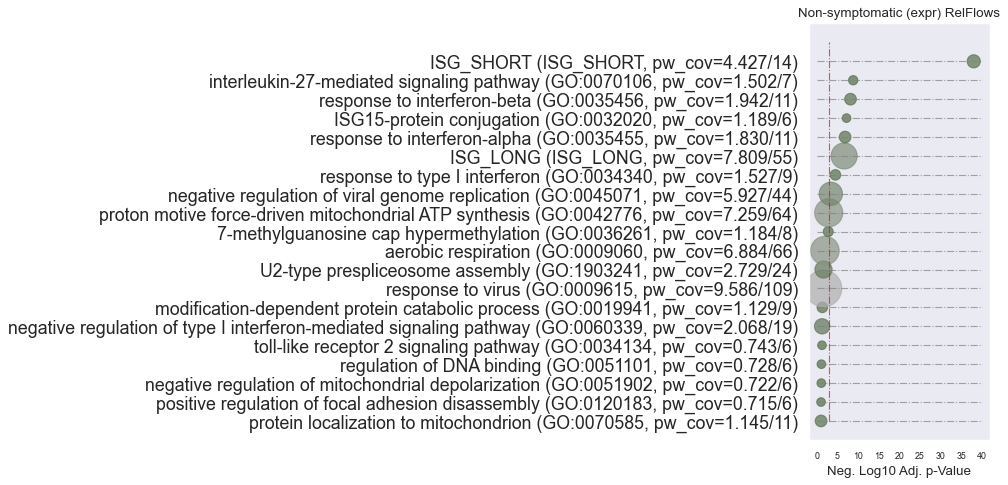

In [21]:
selPWsGrpGO = pwScoresGrpGO[(pwScoresGrpGO["pw_coverage_adj_pval"] < 1) & (pwScoresGrpGO["pwGenes"] > 5)].sort_values("pw_coverage_adj_pval", ascending=True).head(20)
display(selPWsGrpGO)
fa.plotORAresult(selPWsGrpGO, "Non-symptomatic (expr) RelFlows", numResults=20, figsize=(6,6), outfile="plots/asympt_go")

In [22]:
go=fa.get_pathways("go_human.bp.gmt")

Loading pathways from go_human.bp.gmt
Identified 12535 pathways


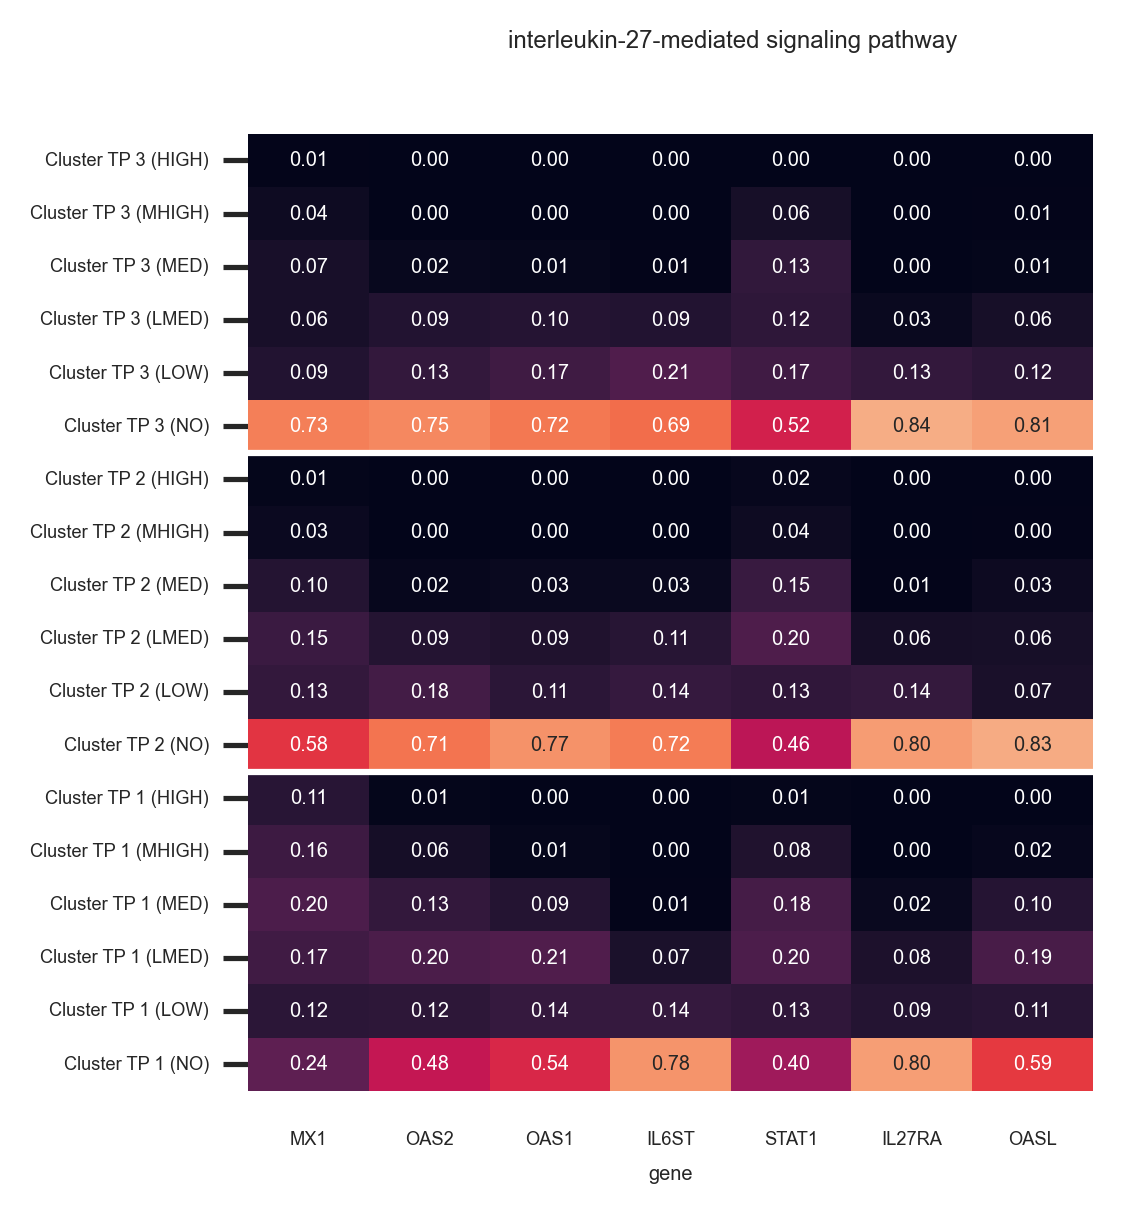

In [23]:
_=fa.plot_state_memberships(go["GO:0070106"][1], name=go["GO:0070106"][0], figsize=(4,4), outfile="plots/GO_0070106_memberships")

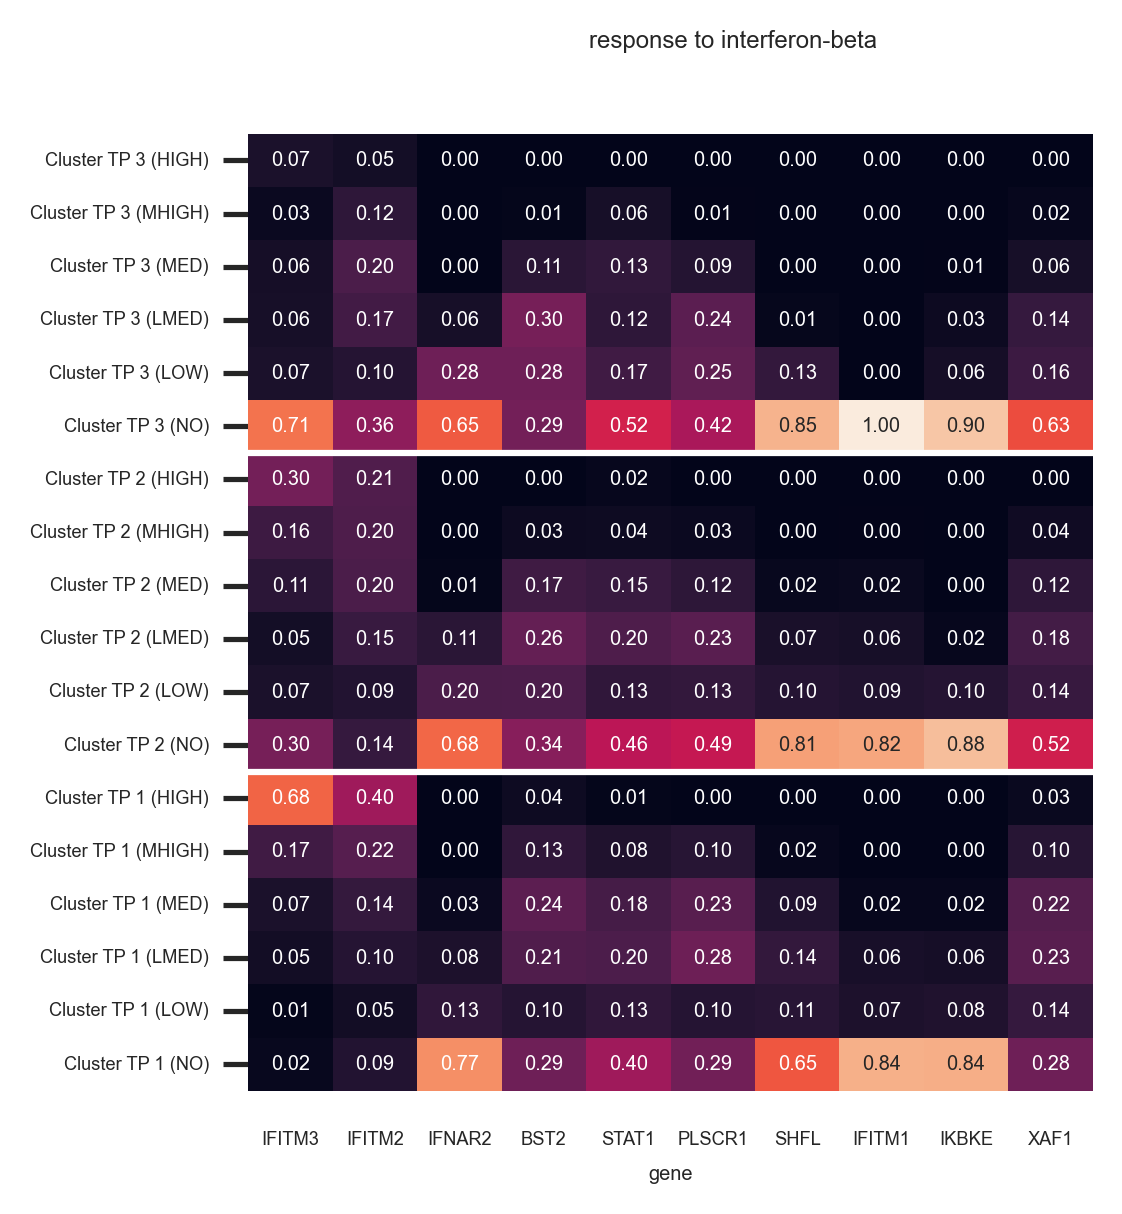

In [24]:
fa.plot_state_memberships(go["GO:0035456"][1], name=go["GO:0035456"][0], figsize=(4,4), outfile="plots/GO_0035456_memberships")